In [36]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import math

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load in Data and First Time Step

In [3]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/poc_config.yaml')
path

PosixPath('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/poc_config.yaml')

In [75]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 50_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }},
                          'input_data':
                              {'input_draw_number': 12
                              }
                          }
    )
sim.setup()

2023-06-07 13:53:51.138 | INFO     | simulation_3-artifact_manager:66 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-06-07 13:53:51.139 | INFO     | simulation_3-artifact_manager:67 - Artifact base filter terms are ['draw == 12'].
2023-06-07 13:53:51.140 | INFO     | simulation_3-artifact_manager:68 - Artifact additional filter terms are None.


In [76]:
pop0 = sim.get_population()
pop0.head()

,tracked,entrance_time,location,sex,age,exit_time,alive,years_of_life_lost,cause_of_death,years_lived_with_disability,...,ldlc_medication,sbp_medication_adherence,sbp_multiplier,lifestyle,ldlc_medication_adherence,polypill,lifestyle_adherence,visit_type,last_fpg_test_date,scheduled_date
0,True,2020-12-04,Alabama,Female,47.388882,NaT,alive,0.0,not_dead,0.0,...,no_treatment,cat3,1.051,NaT,cat3,cat2,True,none,NaT,NaT
1,True,2020-12-04,Alabama,Male,41.564194,NaT,alive,0.0,not_dead,0.0,...,no_treatment,cat3,1.000,NaT,cat3,cat2,False,none,NaT,NaT
2,True,2020-12-04,Alabama,Female,53.155826,NaT,alive,0.0,not_dead,0.0,...,no_treatment,cat3,1.000,NaT,cat3,cat2,False,none,NaT,NaT
3,True,2020-12-04,Alabama,Male,30.457692,NaT,alive,0.0,not_dead,0.0,...,no_treatment,cat3,1.000,NaT,cat1,cat2,True,none,NaT,NaT
4,True,2020-12-04,Alabama,Female,19.554806,NaT,alive,0.0,not_dead,0.0,...,no_treatment,cat3,1.000,NaT,cat3,cat2,False,none,NaT,NaT


In [77]:
pop0.columns

Index(['tracked', 'entrance_time', 'location', 'sex', 'age', 'exit_time',
       'alive', 'years_of_life_lost', 'cause_of_death',
       'years_lived_with_disability', 'previous_ischemic_stroke',
       'previous_ischemic_heart_disease_and_heart_failure',
       'sbp_medication_adherence_propensity',
       'ldlc_medication_adherence_propensity', 'outreach_propensity',
       'polypill_propensity', 'lifestyle_propensity', 'ischemic_stroke',
       'ischemic_heart_disease_and_heart_failure',
       'high_ldl_cholesterol_propensity',
       'ensemble_propensity_risk_factor.high_ldl_cholesterol',
       'high_systolic_blood_pressure_propensity',
       'ensemble_propensity_risk_factor.high_systolic_blood_pressure',
       'high_body_mass_index_in_adults_propensity',
       'ensemble_propensity_risk_factor.high_body_mass_index_in_adults',
       'high_fasting_plasma_glucose_propensity',
       'ensemble_propensity_risk_factor.high_fasting_plasma_glucose',
       'susceptible_to_ischemic_st

In [78]:
sim.list_values()

['metrics',
 'cause_specific_mortality_rate',
 'mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate.paf',
 'disability_weight',
 'sbp_medication_adherence.propensity',
 'sbp_medication_adherence.exposure',
 'risk_factor.sbp_medication_adherence.exposure_parameters',
 'ldlc_medication_adherence.propensity',
 'ldlc_medication_adherence.exposure',
 'risk_factor.ldlc_medication_adherence.exposure_parameters',
 'outreach.propensity',
 'outreach.exposure',
 'risk_factor.outreach.exposure_parameters',
 'risk_factor.outreach.exposure_parameters.paf',
 'polypill.propensity',
 'polypill.exposure',
 'risk_factor.polypill.exposure_parameters',
 'risk_factor.polypill.exposure_parameters.paf',
 'lifestyle.propensity',
 'lifestyle.exposure',
 'risk_factor.lifestyle.exposure_parameters',
 'risk_factor.lifestyle.exposure_parameters.paf',
 'high_ldl_cholesterol.exposure',
 'acute_myocardial_infarction.incidence_rate',
 'acute_myocardia

In [79]:
data1 = pd.concat([pop0,
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('categorical_high_systolic_blood_pressure.exposure')(pop0.index).rename('cat_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('heart_failure_from_ischemic_heart_disease.incidence_rate')(pop0.index).rename('hf_ihd'),
                   sim.get_value('heart_failure_residual.incidence_rate')(pop0.index).rename('hf_resid'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate')(pop0.index).rename('acute_mi'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate')(pop0.index).rename('stroke'),
                  ], axis=1)
data1.head()

,tracked,entrance_time,location,sex,age,exit_time,alive,years_of_life_lost,cause_of_death,years_lived_with_disability,...,scheduled_date,high_ldl,high_sbp,cat_sbp,high_bmi,high_fpg,hf_ihd,hf_resid,acute_mi,stroke
0,True,2020-12-04,Alabama,Female,47.388882,NaT,alive,0.0,not_dead,0.0,...,NaT,3.954473,121.073027,cat3,51.202168,4.118867,0.000067,0.000176,0.000143,8.526964e-05
1,True,2020-12-04,Alabama,Male,41.564194,NaT,alive,0.0,not_dead,0.0,...,NaT,3.517950,142.448350,cat1,23.128022,6.044257,0.000026,0.000074,0.000053,2.909995e-06
2,True,2020-12-04,Alabama,Female,53.155826,NaT,alive,0.0,not_dead,0.0,...,NaT,2.231052,120.992228,cat3,29.662497,9.350924,0.000071,0.000131,0.000031,1.552276e-05
3,True,2020-12-04,Alabama,Male,30.457692,NaT,alive,0.0,not_dead,0.0,...,NaT,4.884755,104.280232,cat4,30.029570,4.653352,0.000013,0.000057,0.000020,8.299417e-07
4,True,2020-12-04,Alabama,Female,19.554806,NaT,alive,0.0,not_dead,0.0,...,NaT,0.000000,50.000000,cat4,5.000000,1.000000,0.000001,0.000026,0.000003,7.382609e-06


In [80]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)

In [81]:
data1.head()

,tracked,entrance_time,location,sex,age,exit_time,alive,years_of_life_lost,cause_of_death,years_lived_with_disability,...,high_ldl,high_sbp,cat_sbp,high_bmi,high_fpg,hf_ihd,hf_resid,acute_mi,stroke,age_start
0,True,2020-12-04,Alabama,Female,47.388882,NaT,alive,0.0,not_dead,0.0,...,3.954473,121.073027,cat3,51.202168,4.118867,0.000067,0.000176,0.000143,8.526964e-05,45.0
1,True,2020-12-04,Alabama,Male,41.564194,NaT,alive,0.0,not_dead,0.0,...,3.517950,142.448350,cat1,23.128022,6.044257,0.000026,0.000074,0.000053,2.909995e-06,40.0
2,True,2020-12-04,Alabama,Female,53.155826,NaT,alive,0.0,not_dead,0.0,...,2.231052,120.992228,cat3,29.662497,9.350924,0.000071,0.000131,0.000031,1.552276e-05,50.0
3,True,2020-12-04,Alabama,Male,30.457692,NaT,alive,0.0,not_dead,0.0,...,4.884755,104.280232,cat4,30.029570,4.653352,0.000013,0.000057,0.000020,8.299417e-07,30.0
6,True,2020-12-04,Alabama,Male,28.652525,NaT,alive,0.0,not_dead,0.0,...,2.362193,124.021805,cat3,24.965181,5.784724,0.000012,0.000081,0.000002,3.268804e-07,25.0


# Relative Risk Regression Graphs 

In [82]:
tmrel_ldl = 1
tmrel_sbp = 112.5
tmrel_bmi = 22.5
tmrel_fpg = 5.1

In [83]:
data_regression = data1[['age_start','sex','high_ldl','high_sbp','high_bmi','cat_sbp','high_fpg','acute_mi','stroke','hf_ihd','hf_resid']]
data_regression['sbp_exposure'] = np.where(data_regression.high_sbp < tmrel_sbp, 0, (data_regression.high_sbp - tmrel_sbp)/10)
data_regression['ldl_exposure'] = np.where(data_regression.high_ldl < tmrel_ldl, 0, (data_regression.high_ldl - tmrel_ldl))
data_regression['bmi_exposure'] = np.where(data_regression.high_bmi < tmrel_bmi, 0, (data_regression.high_bmi - tmrel_bmi)/5)
data_regression['fpg_exposure'] = np.where(data_regression.high_fpg < tmrel_fpg, 0, (data_regression.high_fpg - tmrel_fpg))
data_regression = data_regression.loc[data_regression.age_start < 100]
data_regression.head()

,age_start,sex,high_ldl,high_sbp,high_bmi,cat_sbp,high_fpg,acute_mi,stroke,hf_ihd,hf_resid,sbp_exposure,ldl_exposure,bmi_exposure,fpg_exposure
0,45.0,Female,3.954473,121.073027,51.202168,cat3,4.118867,0.000143,8.526964e-05,0.000067,0.000176,0.857303,2.954473,5.740434,0.000000
1,40.0,Male,3.517950,142.448350,23.128022,cat1,6.044257,0.000053,2.909995e-06,0.000026,0.000074,2.994835,2.517950,0.125604,0.944257
2,50.0,Female,2.231052,120.992228,29.662497,cat3,9.350924,0.000031,1.552276e-05,0.000071,0.000131,0.849223,1.231052,1.432499,4.250924
3,30.0,Male,4.884755,104.280232,30.029570,cat4,4.653352,0.000020,8.299417e-07,0.000013,0.000057,0.000000,3.884755,1.505914,0.000000
6,25.0,Male,2.362193,124.021805,24.965181,cat3,5.784724,0.000002,3.268804e-07,0.000012,0.000081,1.152180,1.362193,0.493036,0.684724


## Acute Myocardial Infarction

### LDL-C

In [84]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("acute_mi ~ ldl_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000037
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000080
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000168
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000126
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000223
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [85]:
df = df.loc[df.index=='ldl_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
ldl_exposure,25.0,Female,1.067784,2.908925
ldl_exposure,25.0,Male,0.819380,2.269092
ldl_exposure,30.0,Female,0.847077,2.332817
ldl_exposure,30.0,Male,0.953648,2.595158
ldl_exposure,35.0,Female,0.619049,1.857162


In [86]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [87]:
rel_risk = art.load('risk_factor.high_ldl_cholesterol.relative_risk')
ldl_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
ldl_rr_mi = ldl_rr.loc[ldl_rr['affected_entity']=='acute_myocardial_infarction']
ldl_rr_mi.head()

,affected_entity,age_start,sex,mean
30,acute_myocardial_infarction,25.0,Female,2.0053
31,acute_myocardial_infarction,25.0,Male,2.0053
32,acute_myocardial_infarction,30.0,Female,2.0267
33,acute_myocardial_infarction,30.0,Male,2.0267
34,acute_myocardial_infarction,35.0,Female,2.0483


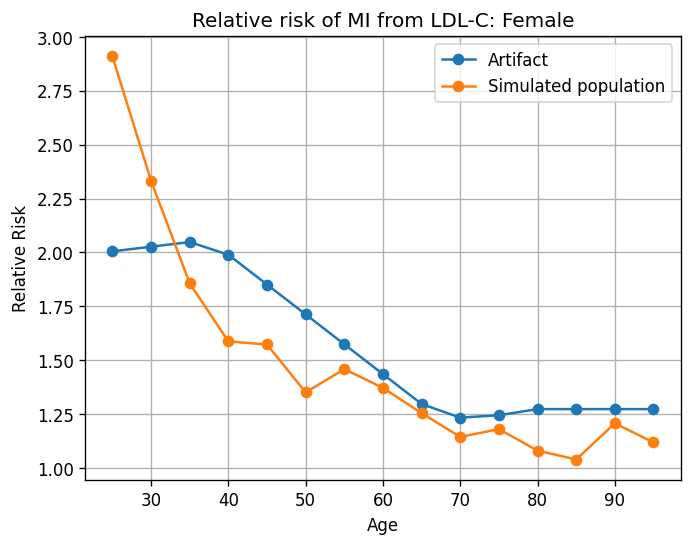

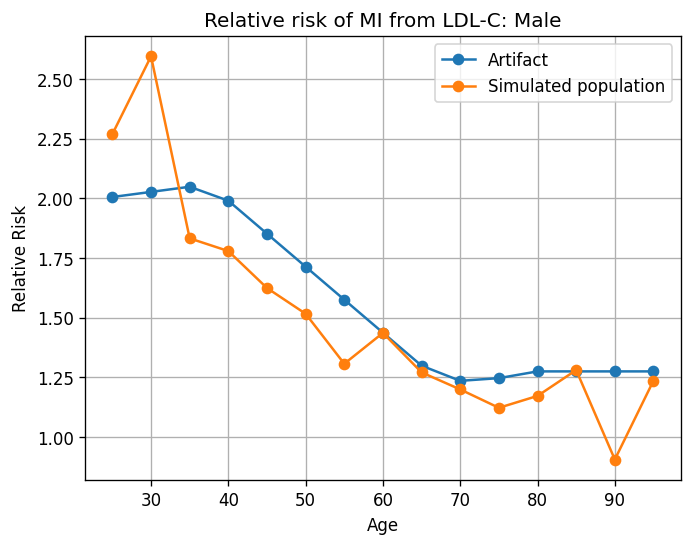

In [88]:
with PdfPages('MI_ldl_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = ldl_rr_mi.loc[ldl_rr_mi['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of MI from LDL-C: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### SBP 

In [89]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("acute_mi ~ sbp_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000037
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000080
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000168
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000126
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000223
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [90]:
df = df.loc[df.index=='sbp_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
sbp_exposure,25.0,Female,0.672111,1.958366
sbp_exposure,25.0,Male,0.727608,2.070123
sbp_exposure,30.0,Female,0.691808,1.997323
sbp_exposure,30.0,Male,0.706080,2.026034
sbp_exposure,35.0,Female,0.537409,1.711566


In [91]:
rel_risk = art.load('risk_factor.high_systolic_blood_pressure.relative_risk')
mi_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
mi_rr = mi_rr.loc[mi_rr['affected_entity']=='acute_myocardial_infarction']
mi_rr.head()

,affected_entity,age_start,sex,mean
30,acute_myocardial_infarction,25.0,Female,2.0317
31,acute_myocardial_infarction,25.0,Male,2.0317
32,acute_myocardial_infarction,30.0,Female,1.8558
33,acute_myocardial_infarction,30.0,Male,1.8558
34,acute_myocardial_infarction,35.0,Female,1.6799


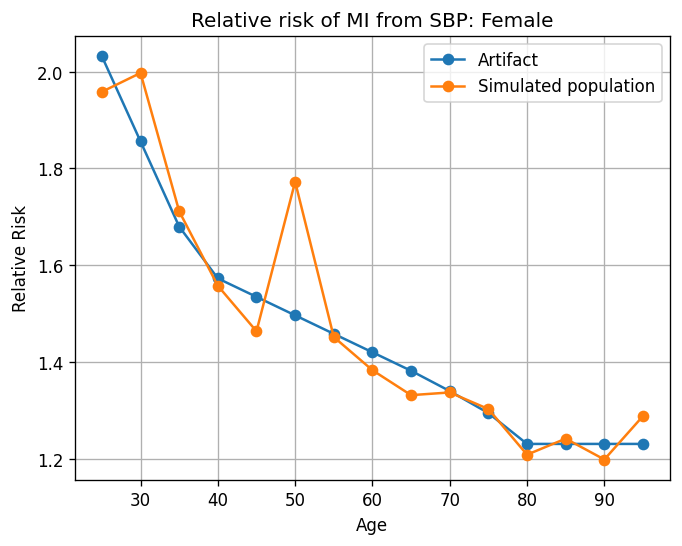

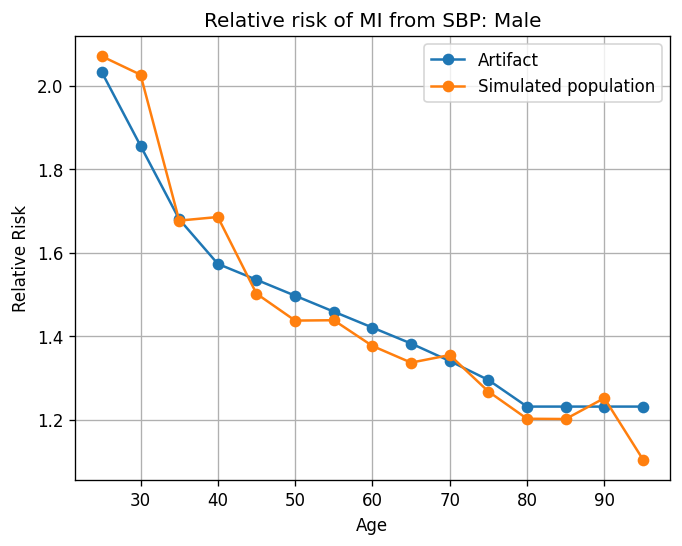

In [92]:
with PdfPages('MI_sbp_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = mi_rr.loc[mi_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of MI from SBP: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### FPG

In [93]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("acute_mi ~ fpg_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000037
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000080
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000168
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000126
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000223
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [94]:
df = df.loc[df.index=='fpg_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
fpg_exposure,25.0,Female,0.283299,1.327502
fpg_exposure,25.0,Male,0.235033,1.264951
fpg_exposure,30.0,Female,0.132394,1.141558
fpg_exposure,30.0,Male,0.225295,1.252692
fpg_exposure,35.0,Female,0.183321,1.201199


In [95]:
rel_risk = art.load('risk_factor.high_fasting_plasma_glucose.relative_risk')
mi_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
mi_rr = mi_rr.loc[mi_rr['affected_entity']=='acute_myocardial_infarction']
mi_rr.head()

,affected_entity,age_start,sex,mean
30,acute_myocardial_infarction,25.0,Female,1.9325
31,acute_myocardial_infarction,25.0,Male,1.9325
32,acute_myocardial_infarction,30.0,Female,1.6915
33,acute_myocardial_infarction,30.0,Male,1.6915
34,acute_myocardial_infarction,35.0,Female,1.4505


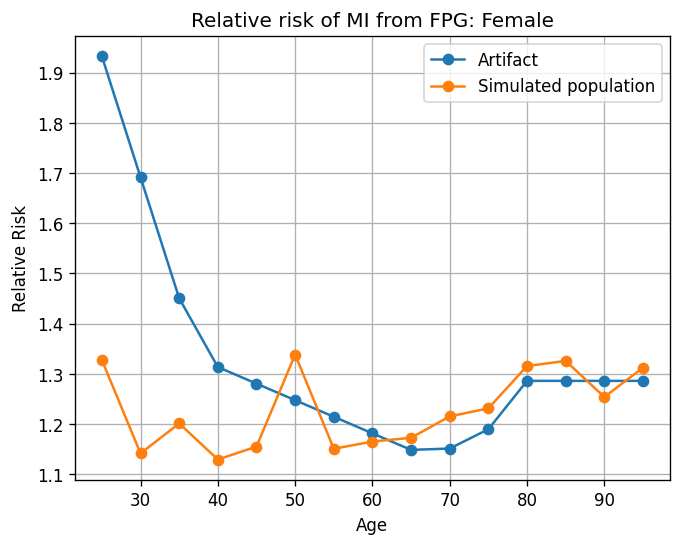

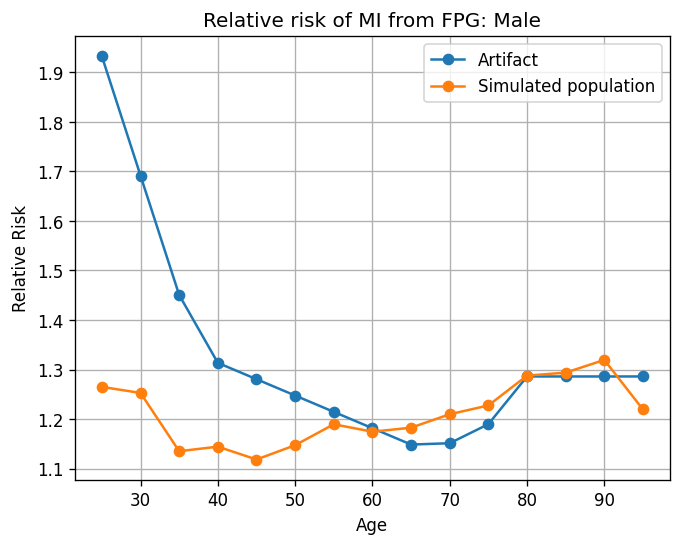

In [96]:
with PdfPages('MI_fpg_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = mi_rr.loc[mi_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of MI from FPG: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### BMI

In [97]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("acute_mi ~ bmi_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000037
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000080
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000168
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000126
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000223
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [98]:
df = df.loc[df.index=='bmi_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
bmi_exposure,25.0,Female,0.814730,2.258565
bmi_exposure,25.0,Male,0.696489,2.006695
bmi_exposure,30.0,Female,0.606059,1.833192
bmi_exposure,30.0,Male,0.646692,1.909214
bmi_exposure,35.0,Female,0.361077,1.434874


In [99]:
rel_risk = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk')
mi_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
mi_rr = mi_rr.loc[mi_rr['affected_entity']=='acute_myocardial_infarction']
mi_rr.head()

,affected_entity,age_start,sex,mean
30,acute_myocardial_infarction,25.0,Female,3.510608
31,acute_myocardial_infarction,25.0,Male,3.510608
32,acute_myocardial_infarction,30.0,Female,2.094858
33,acute_myocardial_infarction,30.0,Male,2.094858
34,acute_myocardial_infarction,35.0,Female,1.685112


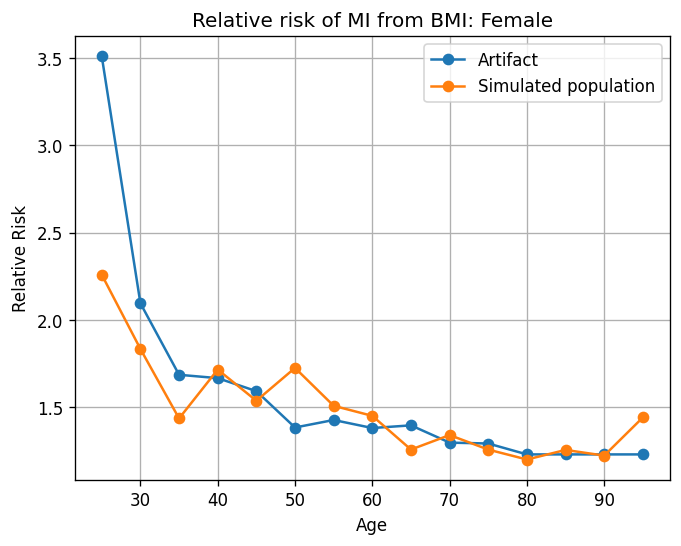

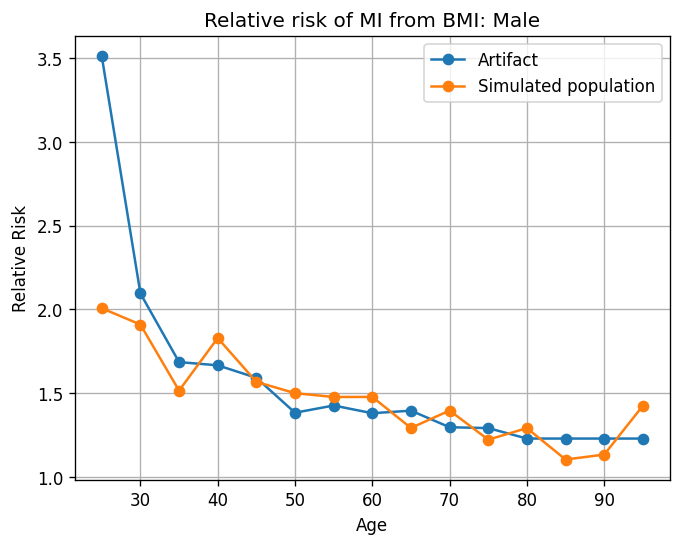

In [100]:
with PdfPages('MI_bmi_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = mi_rr.loc[mi_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of MI from BMI: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

## Stroke 

### LDL-C

In [101]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("stroke ~ ldl_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000288
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.000078
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000163
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [102]:
df = df.loc[df.index=='ldl_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
ldl_exposure,25.0,Female,0.455489,1.576945
ldl_exposure,25.0,Male,0.373863,1.453338
ldl_exposure,30.0,Female,0.409637,1.506271
ldl_exposure,30.0,Male,0.460995,1.585651
ldl_exposure,35.0,Female,0.334734,1.397569


In [103]:
rel_risk = art.load('risk_factor.high_ldl_cholesterol.relative_risk')
stroke_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
stroke_rr = stroke_rr.loc[stroke_rr['affected_entity']=='acute_ischemic_stroke']
stroke_rr.head()

,affected_entity,age_start,sex,mean
0,acute_ischemic_stroke,25.0,Female,1.4165
1,acute_ischemic_stroke,25.0,Male,1.4165
2,acute_ischemic_stroke,30.0,Female,1.4715
3,acute_ischemic_stroke,30.0,Male,1.4715
4,acute_ischemic_stroke,35.0,Female,1.5265


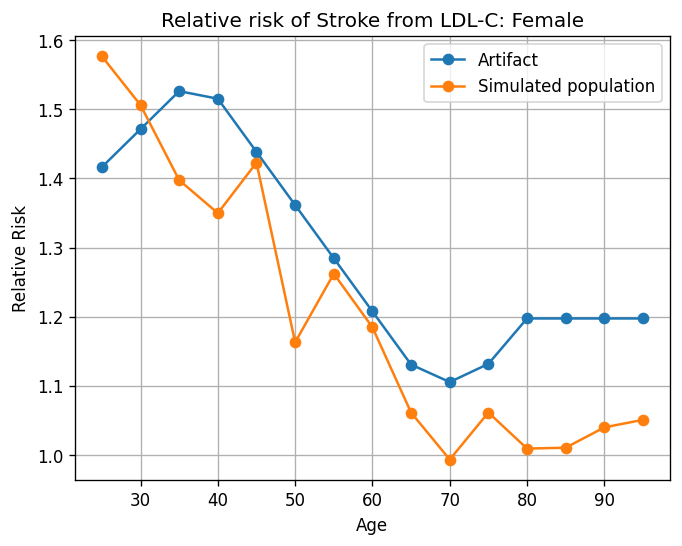

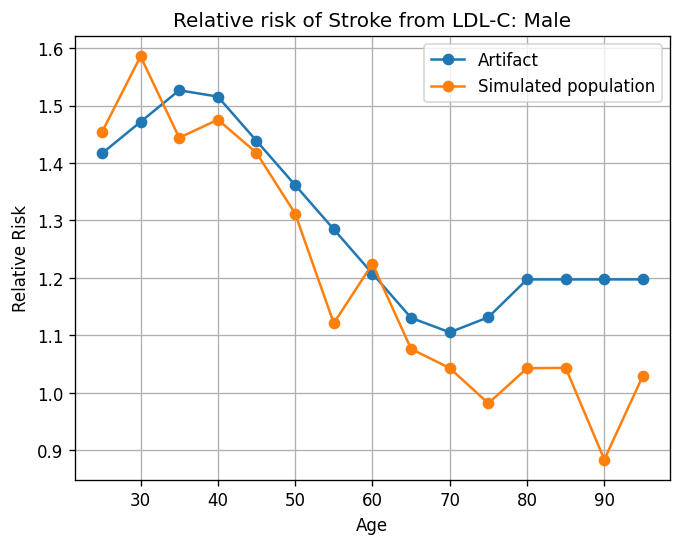

In [104]:
with PdfPages('stroke_ldl_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = stroke_rr.loc[stroke_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of Stroke from LDL-C: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### SBP

In [105]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("stroke ~ sbp_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000289
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000078
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000164
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [106]:
df = df.loc[df.index=='sbp_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
sbp_exposure,25.0,Female,0.658400,1.931699
sbp_exposure,25.0,Male,0.645778,1.907471
sbp_exposure,30.0,Female,0.528273,1.696000
sbp_exposure,30.0,Male,0.581142,1.788079
sbp_exposure,35.0,Female,0.469613,1.599376


In [107]:
rel_risk = art.load('risk_factor.high_systolic_blood_pressure.relative_risk')
stroke_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
stroke_rr = stroke_rr.loc[stroke_rr['affected_entity']=='acute_ischemic_stroke']
stroke_rr.head()

,affected_entity,age_start,sex,mean
0,acute_ischemic_stroke,25.0,Female,1.7644
1,acute_ischemic_stroke,25.0,Male,1.7644
2,acute_ischemic_stroke,30.0,Female,1.7026
3,acute_ischemic_stroke,30.0,Male,1.7026
4,acute_ischemic_stroke,35.0,Female,1.6409


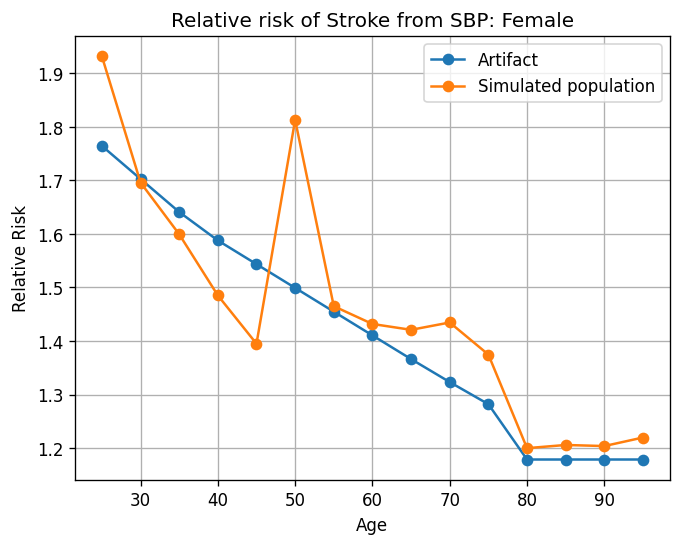

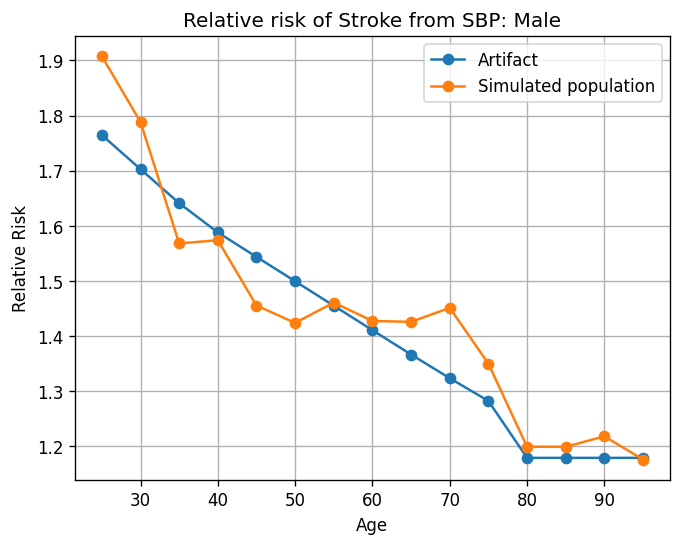

In [108]:
with PdfPages('stroke_sbp_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = stroke_rr.loc[stroke_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of Stroke from SBP: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### FPG

In [109]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("stroke ~ fpg_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000288
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.000078
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000163
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [110]:
df = df.loc[df.index=='fpg_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
fpg_exposure,25.0,Female,0.483012,1.620950
fpg_exposure,25.0,Male,0.399014,1.490355
fpg_exposure,30.0,Female,0.289147,1.335288
fpg_exposure,30.0,Male,0.345962,1.413349
fpg_exposure,35.0,Female,0.233708,1.263275


In [111]:
rel_risk = art.load('risk_factor.high_fasting_plasma_glucose.relative_risk')
stroke_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
stroke_rr = stroke_rr.loc[stroke_rr['affected_entity']=='acute_ischemic_stroke']
stroke_rr.head()

,affected_entity,age_start,sex,mean
0,acute_ischemic_stroke,25.0,Female,1.5236
1,acute_ischemic_stroke,25.0,Male,1.5236
2,acute_ischemic_stroke,30.0,Female,1.3974
3,acute_ischemic_stroke,30.0,Male,1.3974
4,acute_ischemic_stroke,35.0,Female,1.2711


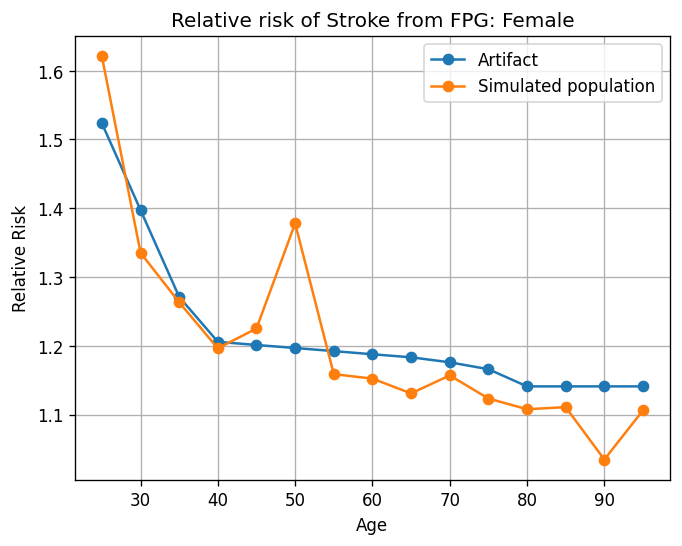

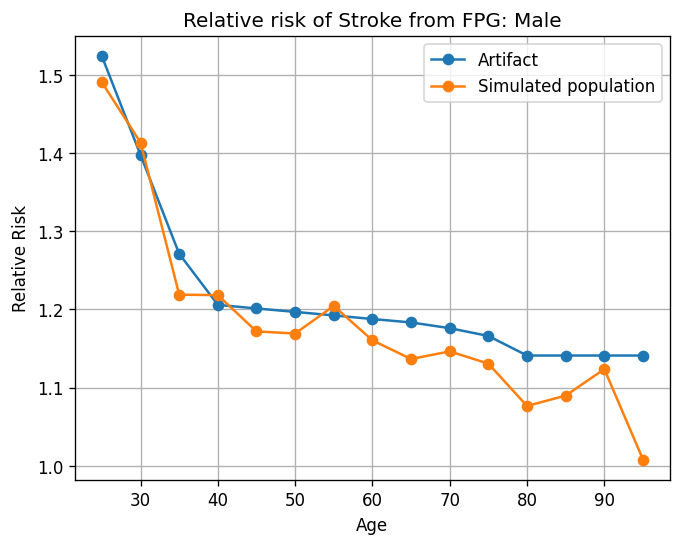

In [112]:
with PdfPages('stroke_fpg_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = stroke_rr.loc[stroke_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of Stroke from FPG: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### BMI

In [113]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("stroke ~ bmi_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.000288
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.000078
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000163
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [114]:
df = df.loc[df.index=='bmi_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
bmi_exposure,25.0,Female,0.659676,1.934165
bmi_exposure,25.0,Male,0.590141,1.804242
bmi_exposure,30.0,Female,0.556280,1.744172
bmi_exposure,30.0,Male,0.626510,1.871069
bmi_exposure,35.0,Female,0.683138,1.980082


In [115]:
rel_risk = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk')
stroke_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
stroke_rr = stroke_rr.loc[stroke_rr['affected_entity']=='acute_ischemic_stroke']
stroke_rr.head()

,affected_entity,age_start,sex,mean
0,acute_ischemic_stroke,25.0,Female,2.405075
1,acute_ischemic_stroke,25.0,Male,2.405075
2,acute_ischemic_stroke,30.0,Female,2.220086
3,acute_ischemic_stroke,30.0,Male,2.220086
4,acute_ischemic_stroke,35.0,Female,1.919950


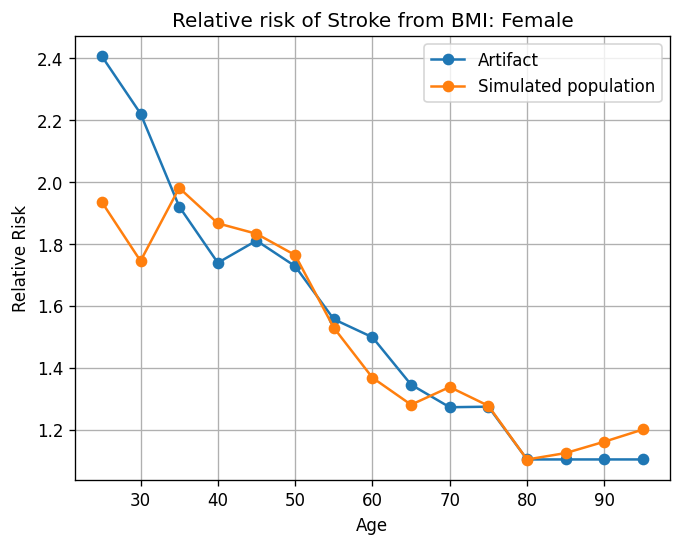

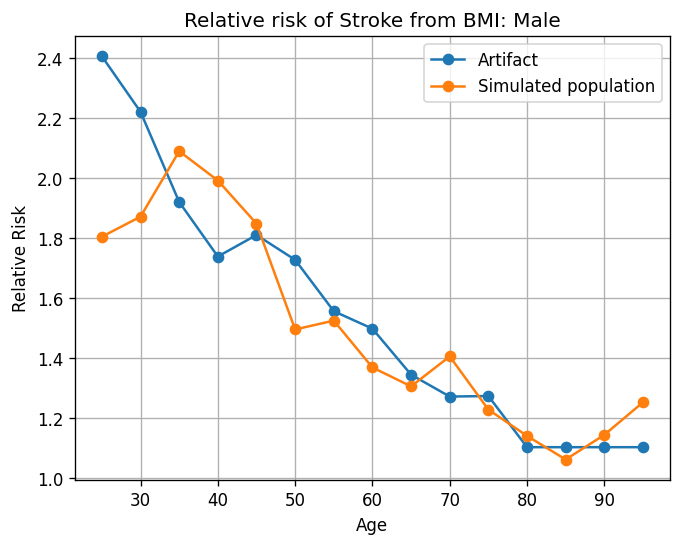

In [116]:
with PdfPages('stroke_bmi_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = stroke_rr.loc[stroke_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of Stroke from BMI: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

## Heart Failure 

### BMI

In [46]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("hf_resid ~ bmi_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000079
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000114
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000655
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.000169
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000258
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.

/tmp/ipykernel_3168500/72871723.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/72871723.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/72871723.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/72871723.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/72871723.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results

Optimization terminated successfully.
         Current function value: 0.000975
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007583
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.002658
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.008099
         Iterations 9


/tmp/ipykernel_3168500/72871723.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/72871723.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/72871723.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/72871723.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)


In [47]:
df = df.loc[df.index=='bmi_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
bmi_exposure,25.0,Female,0.123855,1.131851
bmi_exposure,25.0,Male,0.125420,1.133624
bmi_exposure,30.0,Female,0.121930,1.129675
bmi_exposure,30.0,Male,0.126669,1.135041
bmi_exposure,35.0,Female,0.124632,1.132732


In [48]:
rel_risk = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk')
hf_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
hf_rr = hf_rr.loc[hf_rr['affected_entity']=='heart_failure_residual']
hf_rr.head()

,affected_entity,age_start,sex,mean
120,heart_failure_residual,25.0,Female,1.134219
121,heart_failure_residual,25.0,Male,1.134219
122,heart_failure_residual,30.0,Female,1.134219
123,heart_failure_residual,30.0,Male,1.134219
124,heart_failure_residual,35.0,Female,1.134219


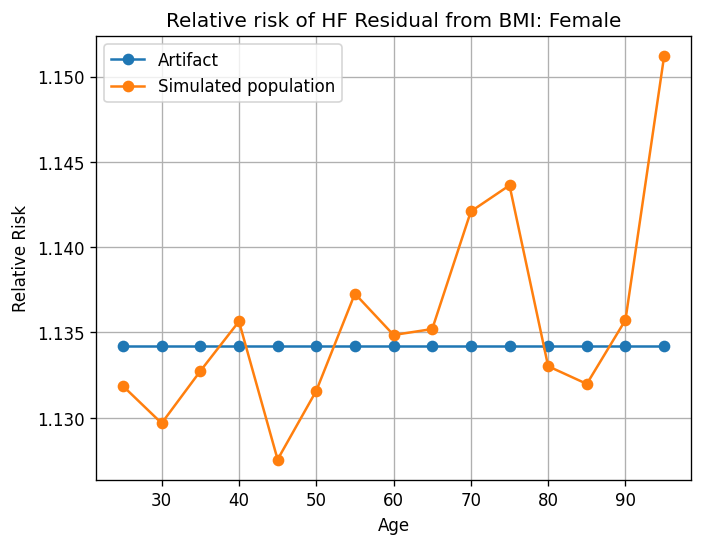

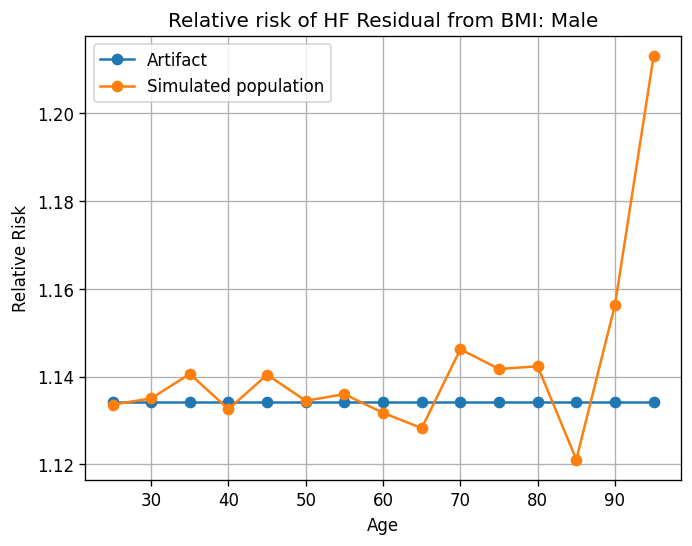

In [49]:
with PdfPages('hf_resid_bmi_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = hf_rr.loc[hf_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of HF Residual from BMI: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

In [50]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("hf_ihd ~ bmi_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000030
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000062
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000550
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.000115
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000217
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

/tmp/ipykernel_3168500/2897964424.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/2897964424.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/2897964424.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/2897964424.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/2897964424.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.appe

Optimization terminated successfully.
         Current function value: 0.006072
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.001097
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010324
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.003180
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.012835
         Iterations 9


/tmp/ipykernel_3168500/2897964424.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/2897964424.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/2897964424.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/2897964424.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_df)
/tmp/ipykernel_3168500/2897964424.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.appe

In [51]:
df = df.loc[df.index=='bmi_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
bmi_exposure,25.0,Female,0.123849,1.131845
bmi_exposure,25.0,Male,0.125412,1.133615
bmi_exposure,30.0,Female,0.121925,1.129669
bmi_exposure,30.0,Male,0.126661,1.135032
bmi_exposure,35.0,Female,0.124629,1.132729


In [52]:
rel_risk = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk')
hf_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
hf_rr = hf_rr.loc[hf_rr['affected_entity']=='heart_failure_from_ischemic_heart_disease']
hf_rr.head()

,affected_entity,age_start,sex,mean
90,heart_failure_from_ischemic_heart_disease,25.0,Female,1.134219
91,heart_failure_from_ischemic_heart_disease,25.0,Male,1.134219
92,heart_failure_from_ischemic_heart_disease,30.0,Female,1.134219
93,heart_failure_from_ischemic_heart_disease,30.0,Male,1.134219
94,heart_failure_from_ischemic_heart_disease,35.0,Female,1.134219


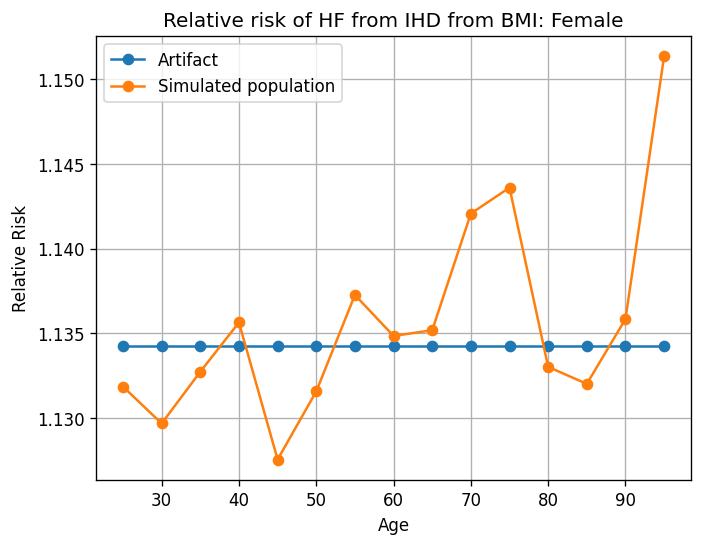

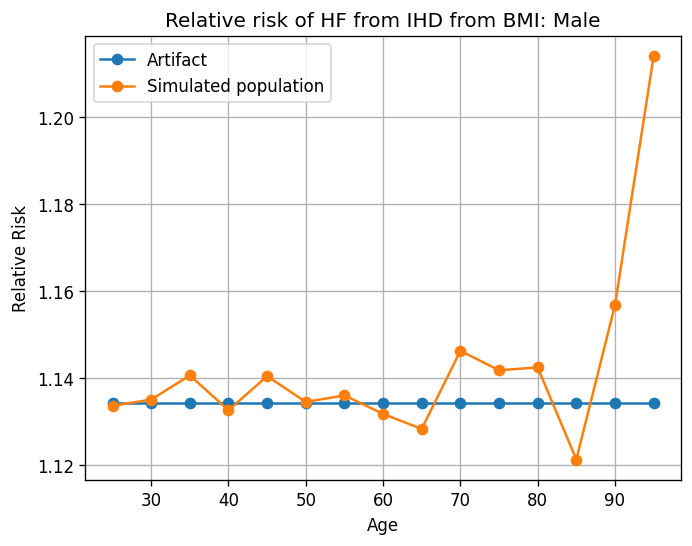

In [53]:
with PdfPages('hf_ihd_bmi_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = hf_rr.loc[hf_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of HF from IHD from BMI: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### SBP (categorical)

In [62]:
df = pd.DataFrame() 
for age in data_regression.age_start.unique(): 
    for sex in data_regression.sex.unique():
        subdata1 = data_regression.loc[(data_regression.age_start == age) & (data_regression.sex == sex) & (data_regression.cat_sbp == 'cat4')] 
        mean_4 = subdata1.hf_ihd.mean()
        for cat in data_regression.cat_sbp.unique():
            rrs_temp = pd.DataFrame()
            subdata = data_regression.loc[(data_regression.age_start == age) & (data_regression.sex == sex) & (data_regression.cat_sbp == cat)] 
            mean = subdata.hf_ihd.mean()
            rr = mean/mean_4
            rrs_temp = pd.DataFrame({"age":age,
                             "sex": sex,
                               "Category":cat,
                               "RR":rr}, index=[1,2,3,4])
            df = df.append(rrs_temp)

In [65]:
df = df.sort_values(by=['age','Category'])
df.head()

,age,sex,Category,RR
1,25.0,Female,cat1,1.541265
2,25.0,Female,cat1,1.541265
3,25.0,Female,cat1,1.541265
4,25.0,Female,cat1,1.541265
1,25.0,Male,cat1,1.653104


In [43]:
rel_risk = art.load('risk_factor.categorical_high_systolic_blood_pressure.relative_risk')
hf_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex','parameter'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
hf_rr = hf_rr.loc[hf_rr['affected_entity']=='heart_failure_from_ischemic_heart_disease']
hf_rr.head()

,affected_entity,age_start,sex,parameter,mean
0,heart_failure_from_ischemic_heart_disease,25.0,Female,cat1,1.645682
1,heart_failure_from_ischemic_heart_disease,25.0,Female,cat2,1.466387
2,heart_failure_from_ischemic_heart_disease,25.0,Female,cat3,1.219001
3,heart_failure_from_ischemic_heart_disease,25.0,Female,cat4,1.000000
4,heart_failure_from_ischemic_heart_disease,25.0,Male,cat1,1.645682


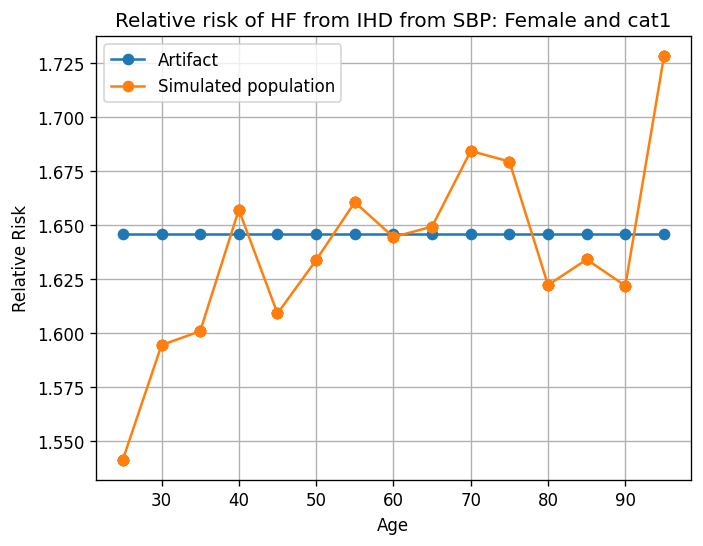

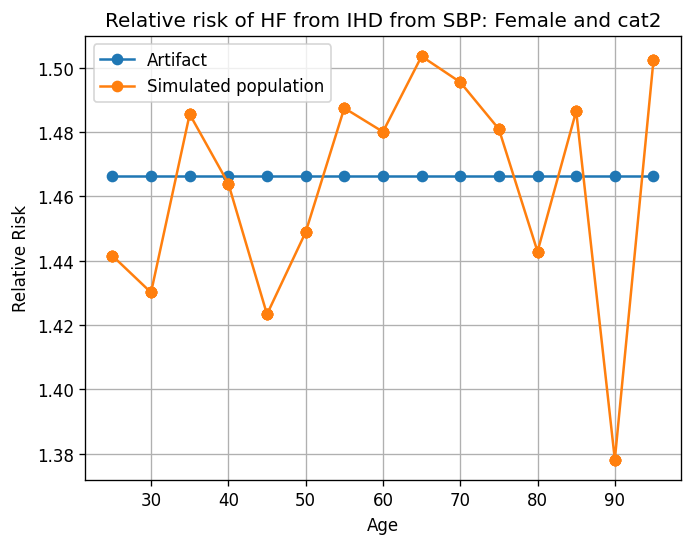

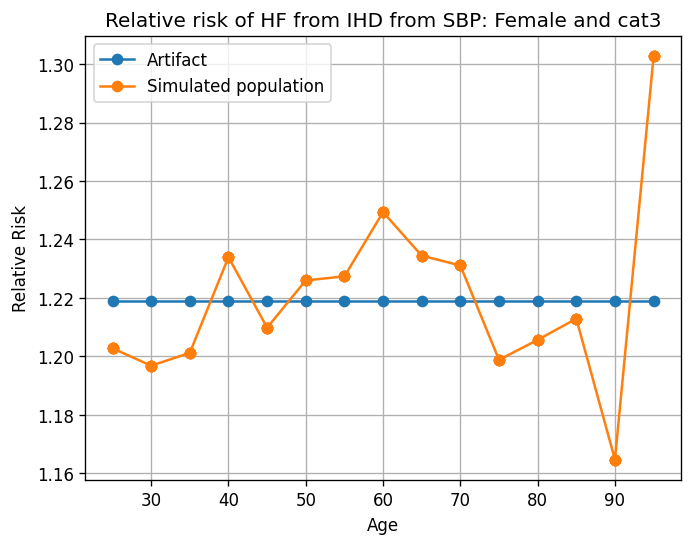

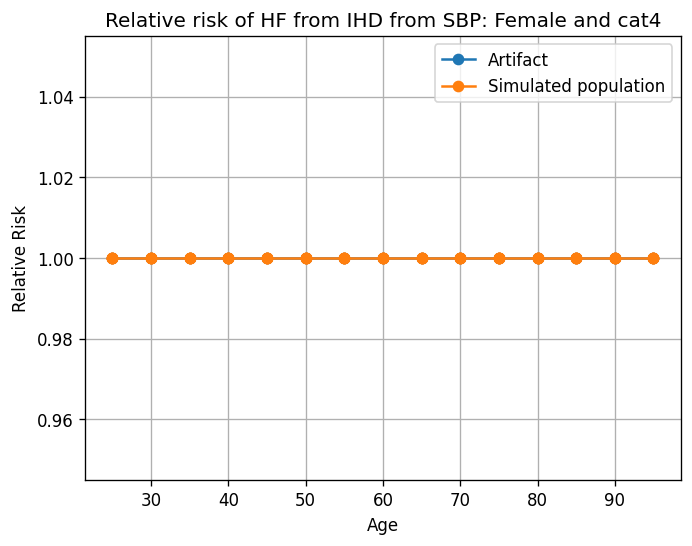

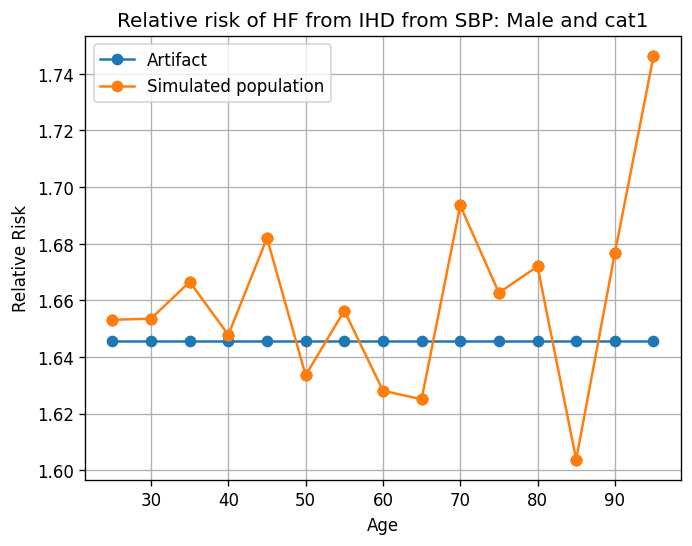

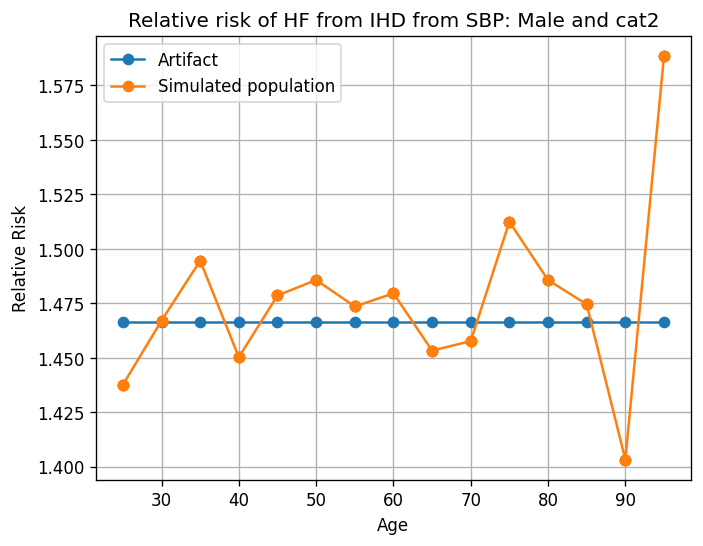

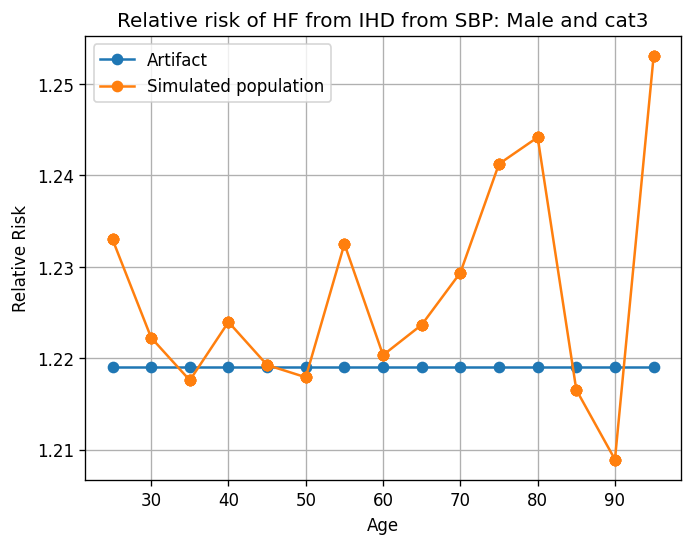

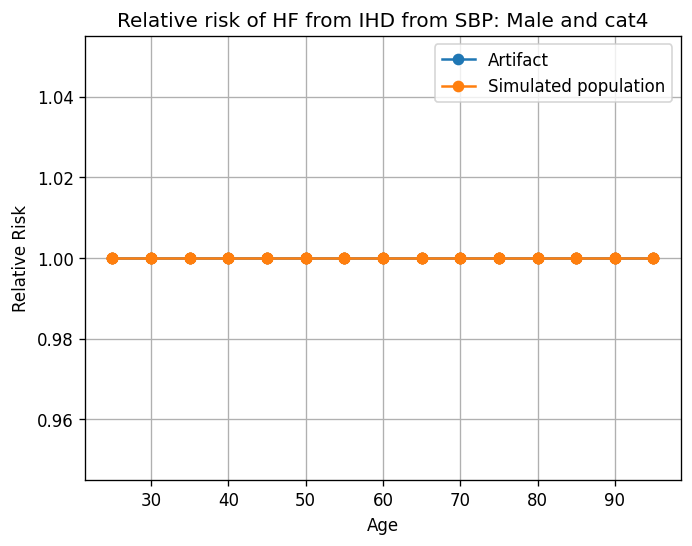

In [66]:
with PdfPages('hf_ihd_sbp_rr.pdf') as pdf:
    for sex in df.sex.unique():
        for cat in df.Category.unique():
            plt.figure(dpi=120)
            subdata = hf_rr.loc[(hf_rr['sex']==sex) & (hf_rr['parameter']==cat)]
            plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
            subdata2 = df.loc[(df['sex']==sex) & (df['Category']==cat)]
            plt.plot(subdata2.age, subdata2.RR, marker='o', label='Simulated population')
            plt.title(f'Relative risk of HF from IHD from SBP: {sex} and {cat}') 
            plt.ylabel('Relative Risk')
            plt.xlabel('Age')
            plt.legend()
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [67]:
df = pd.DataFrame() 
for age in data_regression.age_start.unique(): 
    for sex in data_regression.sex.unique():
        subdata1 = data_regression.loc[(data_regression.age_start == age) & (data_regression.sex == sex) & (data_regression.cat_sbp == 'cat4')] 
        mean_4 = subdata1.hf_resid.mean()
        for cat in data_regression.cat_sbp.unique():
            rrs_temp = pd.DataFrame()
            subdata = data_regression.loc[(data_regression.age_start == age) & (data_regression.sex == sex) & (data_regression.cat_sbp == cat)] 
            mean = subdata.hf_resid.mean()
            rr = mean/mean_4
            rrs_temp = pd.DataFrame({"age":age,
                             "sex": sex,
                               "Category":cat,
                               "RR":rr}, index=[1,2,3,4])
            df = df.append(rrs_temp)

In [68]:
df = df.sort_values(by=['age','Category'])
df.head()

,age,sex,Category,RR
1,25.0,Female,cat1,1.541265
2,25.0,Female,cat1,1.541265
3,25.0,Female,cat1,1.541265
4,25.0,Female,cat1,1.541265
1,25.0,Male,cat1,1.653104


In [69]:
rel_risk = art.load('risk_factor.categorical_high_systolic_blood_pressure.relative_risk')
hf_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex','parameter'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
hf_rr = hf_rr.loc[hf_rr['affected_entity']=='heart_failure_residual']
hf_rr.head()

,affected_entity,age_start,sex,parameter,mean
120,heart_failure_residual,25.0,Female,cat1,1.645682
121,heart_failure_residual,25.0,Female,cat2,1.466387
122,heart_failure_residual,25.0,Female,cat3,1.219001
123,heart_failure_residual,25.0,Female,cat4,1.000000
124,heart_failure_residual,25.0,Male,cat1,1.645682


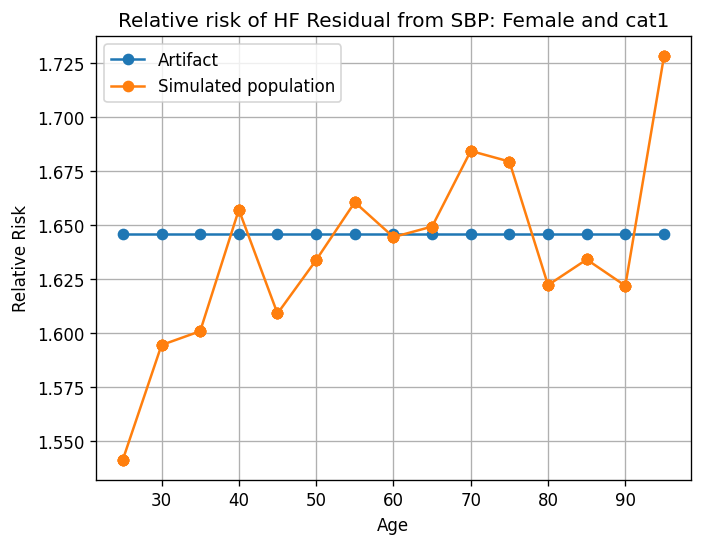

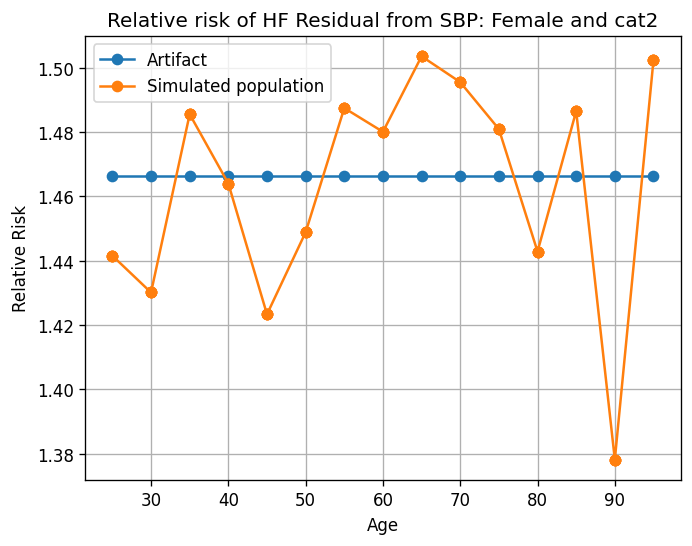

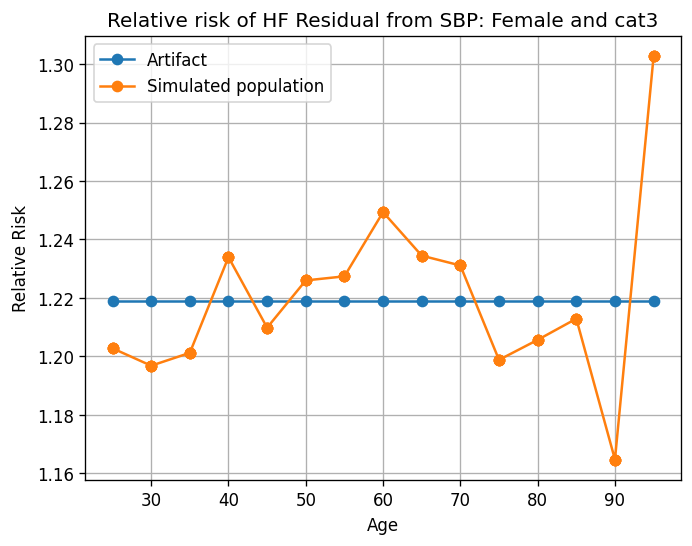

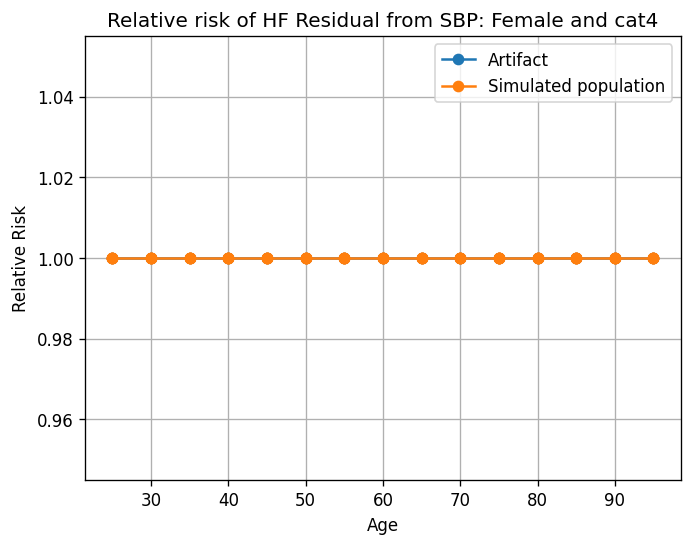

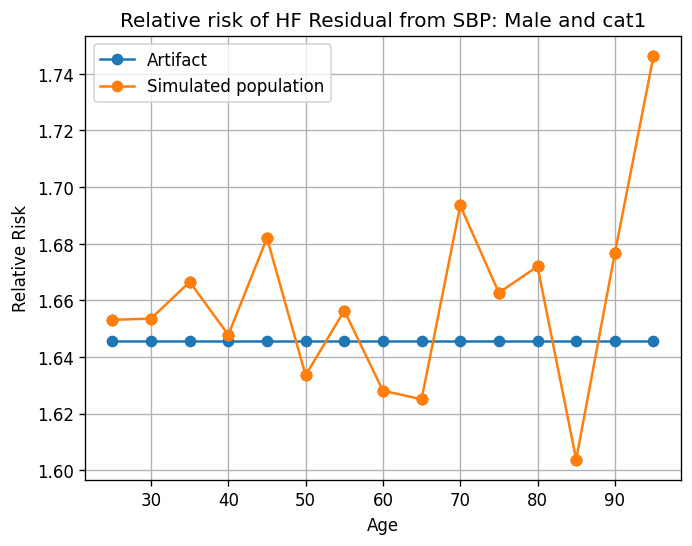

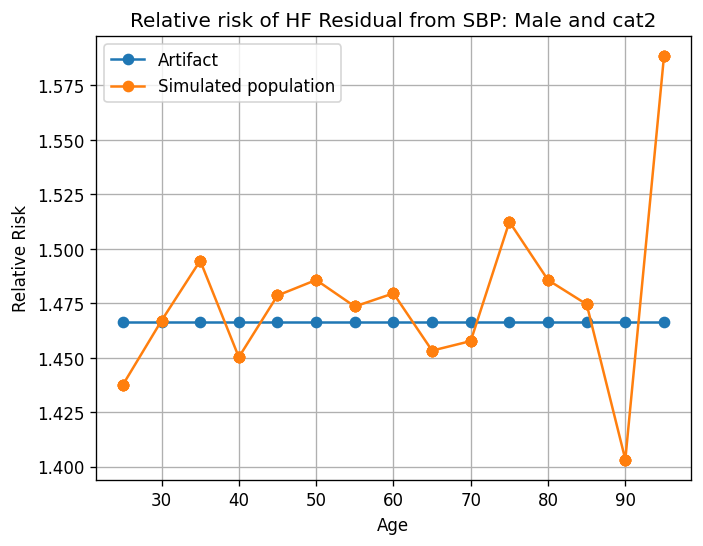

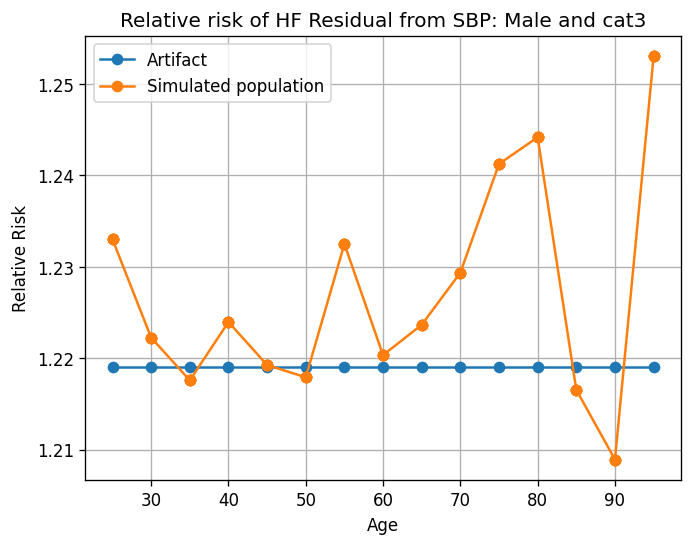

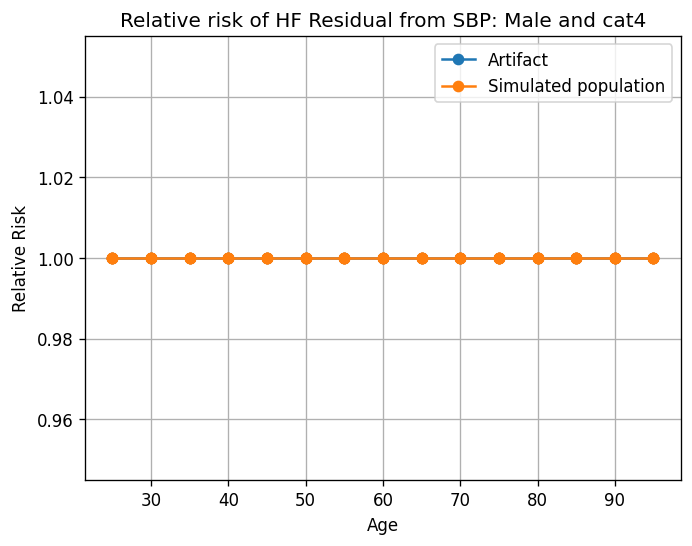

In [70]:
with PdfPages('hf_resid_sbp_rr.pdf') as pdf:
    for sex in df.sex.unique():
        for cat in df.Category.unique():
            plt.figure(dpi=120)
            subdata = hf_rr.loc[(hf_rr['sex']==sex) & (hf_rr['parameter']==cat)]
            plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
            subdata2 = df.loc[(df['sex']==sex) & (df['Category']==cat)]
            plt.plot(subdata2.age, subdata2.RR, marker='o', label='Simulated population')
            plt.title(f'Relative risk of HF Residual from SBP: {sex} and {cat}') 
            plt.ylabel('Relative Risk')
            plt.xlabel('Age')
            plt.legend()
            plt.grid()
            pdf.savefig(bbox_inches='tight')

## Relative Risk Testing

In [13]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/

alabama.hdf  alabama_before_calculated_pafs.hdf  raw_data/  washington.hdf


In [41]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [17]:
def load_artifact_key(word:str, cause:str, measure:str):
    data = pd.DataFrame()
    for i in ['alabama']:
        
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25', 'draw==0']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        data = art.load(word + '.' + cause + '.' + measure)
    return data

## Relative Risks for MI

In [42]:
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
data_MI = data1[['age_start','sex','high_ldl','high_sbp','high_bmi','high_fpg','acute_myocardial_infarction_event_count']]
data_MI['acute_MI_binary'] = np.where(data_MI['acute_myocardial_infarction_event_count'] == 0, 0, 1)
data_MI = data_MI.loc[data_MI['age_start'] > 20]
data_MI.head()

,age_start,sex,high_ldl,high_sbp,high_bmi,high_fpg,acute_myocardial_infarction_event_count,acute_MI_binary
0,45.0,Female,2.644998,127.134134,24.802611,6.138124,0,0
1,40.0,Male,3.376564,131.808766,27.165902,4.975500,0,0
2,50.0,Female,2.074324,106.466069,33.998750,7.768995,0,0
3,30.0,Male,3.756715,109.868926,27.233734,5.494943,0,0
6,25.0,Male,3.108510,117.596354,33.562817,5.886765,0,0


In [20]:
art_MI_inc = load_artifact_key('cause', 'myocardial_infarction', 'incidence_rate')
art_MI_inc = art_MI_inc.rename(columns={"draw_0": "inc"}).reset_index()
art_MI_inc.head()

,sex,age_start,age_end,year_start,year_end,inc
0,Female,25.0,30.0,2019,2020,0.000403
1,Female,30.0,35.0,2019,2020,0.000430
2,Female,35.0,40.0,2019,2020,0.000355
3,Female,40.0,45.0,2019,2020,0.000450
4,Female,45.0,50.0,2019,2020,0.000717


In [21]:
art_MI_rr_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'relative_risk')
art_MI_rr_ldl = art_MI_rr_ldl.rename(columns={"draw_0": "rr_ldl"}).reset_index()
art_MI_rr_ldl = art_MI_rr_ldl.loc[art_MI_rr_ldl['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_ldl.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_ldl
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.0053
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.0267
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.0483
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.9898
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.8515


In [22]:
art_MI_rr_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'relative_risk')
art_MI_rr_sbp = art_MI_rr_sbp.rename(columns={"draw_0": "rr_sbp"}).reset_index()
art_MI_rr_sbp = art_MI_rr_sbp.loc[art_MI_rr_sbp['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_sbp.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_sbp
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.0317
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.8558
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.6799
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.5729
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.5348


In [23]:
art_MI_rr_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'relative_risk')
art_MI_rr_bmi = art_MI_rr_bmi.rename(columns={"draw_0": "rr_bmi"}).reset_index()
art_MI_rr_bmi = art_MI_rr_bmi.loc[art_MI_rr_bmi['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_bmi.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_bmi
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,3.510608
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.094858
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.685112
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.665879
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.591258


In [38]:
art_MI_rr_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'relative_risk')
art_MI_rr_fpg = art_MI_rr_fpg.rename(columns={"draw_0": "rr_fpg"}).reset_index()
art_MI_rr_fpg = art_MI_rr_fpg.loc[art_MI_rr_fpg['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_fpg.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_fpg
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.9325
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.6915
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.4505
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.3135
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.2805


In [25]:
art_MI_paf_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'population_attributable_fraction')
art_MI_paf_ldl = art_MI_paf_ldl.rename(columns={"draw_0": "paf_ldl"}).reset_index()
art_MI_paf_ldl = art_MI_paf_ldl.loc[art_MI_paf_ldl['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_ldl.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_ldl
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.703067
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.707316
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.705092
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.685767
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.658356


In [26]:
art_MI_paf_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'population_attributable_fraction')
art_MI_paf_sbp = art_MI_paf_sbp.rename(columns={"draw_0": "paf_sbp"}).reset_index()
art_MI_paf_sbp = art_MI_paf_sbp.loc[art_MI_paf_sbp['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_sbp.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_sbp
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.479086
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.399835
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.448564
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.360870
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.464980


In [27]:
art_MI_paf_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'population_attributable_fraction')
art_MI_paf_bmi = art_MI_paf_bmi.rename(columns={"draw_0": "paf_bmi"}).reset_index()
art_MI_paf_bmi = art_MI_paf_bmi.loc[art_MI_paf_bmi['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_bmi.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_bmi
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.976086
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.811838
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.778104
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.680518
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.657915


In [37]:
art_MI_paf_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'population_attributable_fraction')
art_MI_paf_fpg = art_MI_paf_fpg.rename(columns={"draw_0": "paf_fpg"}).reset_index()
art_MI_paf_fpg = art_MI_paf_fpg.loc[art_MI_paf_fpg['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_fpg.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_fpg
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.410015
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.301534
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.221111
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.184682
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.164129


In [29]:
rrs_sbp = get_draws(gbd_id_type='rei_id',
               gbd_id=107,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_sbp = rrs_sbp.loc[rrs_sbp.cause_id==493]
rrs_sbp = rrs_sbp[['age_group_id','sex_id','draw_0']]
rrs_sbp['age_start'] = np.where(rrs_sbp['age_group_id']==10,25,np.where(rrs_sbp['age_group_id']==11,30,np.where(rrs_sbp['age_group_id']==12,35,np.where(rrs_sbp['age_group_id']==13,40,np.where(rrs_sbp['age_group_id']==14,45,np.where(rrs_sbp['age_group_id']==15,50,np.where(rrs_sbp['age_group_id']==16,55,np.where(rrs_sbp['age_group_id']==17,60,np.where(rrs_sbp['age_group_id']==18,65,np.where(rrs_sbp['age_group_id']==19,70,np.where(rrs_sbp['age_group_id']==20,75,np.where(rrs_sbp['age_group_id']==30,80,np.where(rrs_sbp['age_group_id']==31,85,np.where(rrs_sbp['age_group_id']==32,90,0))))))))))))))
rrs_sbp['sex'] = np.where(rrs_sbp['sex_id']==1,'Male','Female')
rrs_sbp = rrs_sbp.rename(columns={"draw_0": "rr_gbd_sbp"}).reset_index()
rrs_sbp.head()

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id
/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/base/utils.py:30: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in df.groupby([group_cols]):


,index,age_group_id,sex_id,rr_gbd_sbp,age_start,sex
0,55,10,1,2.0317,25,Male
1,56,11,1,1.8558,30,Male
2,57,12,1,1.6799,35,Male
3,58,13,1,1.5729,40,Male
4,59,14,1,1.5348,45,Male


In [30]:
rrs = get_draws(gbd_id_type='rei_id',
               gbd_id=367,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs = rrs.loc[rrs.cause_id==493]
rrs = rrs[['age_group_id','sex_id','draw_0']]
rrs['age_start'] = np.where(rrs['age_group_id']==10,25,np.where(rrs['age_group_id']==11,30,np.where(rrs['age_group_id']==12,35,np.where(rrs['age_group_id']==13,40,np.where(rrs['age_group_id']==14,45,np.where(rrs['age_group_id']==15,50,np.where(rrs['age_group_id']==16,55,np.where(rrs['age_group_id']==17,60,np.where(rrs['age_group_id']==18,65,np.where(rrs['age_group_id']==19,70,np.where(rrs['age_group_id']==20,75,np.where(rrs['age_group_id']==30,80,np.where(rrs['age_group_id']==31,85,np.where(rrs['age_group_id']==32,90,0))))))))))))))
rrs['sex'] = np.where(rrs['sex_id']==1,'Male','Female')
rrs = rrs.rename(columns={"draw_0": "rr_gbd_ldl"}).reset_index()
rrs.head()

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id
/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/base/utils.py:30: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in df.groupby([group_cols]):


,index,age_group_id,sex_id,rr_gbd_ldl,age_start,sex
0,0,10,1,2.0053,25,Male
1,1,11,1,2.0267,30,Male
2,2,12,1,2.0483,35,Male
3,3,13,1,1.9898,40,Male
4,4,14,1,1.8515,45,Male


In [31]:
rrs_bmi = get_draws(gbd_id_type='rei_id',
               gbd_id=370,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_bmi = rrs_bmi.loc[rrs_bmi.cause_id==493]
rrs_bmi = rrs_bmi[['age_group_id','sex_id','draw_0']]
rrs_bmi['age_start'] = np.where(rrs_bmi['age_group_id']==10,25,np.where(rrs_bmi['age_group_id']==11,30,np.where(rrs_bmi['age_group_id']==12,35,np.where(rrs_bmi['age_group_id']==13,40,np.where(rrs_bmi['age_group_id']==14,45,np.where(rrs_bmi['age_group_id']==15,50,np.where(rrs_bmi['age_group_id']==16,55,np.where(rrs_bmi['age_group_id']==17,60,np.where(rrs_bmi['age_group_id']==18,65,np.where(rrs_bmi['age_group_id']==19,70,np.where(rrs_bmi['age_group_id']==20,75,np.where(rrs_bmi['age_group_id']==30,80,np.where(rrs_bmi['age_group_id']==31,85,np.where(rrs_bmi['age_group_id']==32,90,0))))))))))))))
rrs_bmi['sex'] = np.where(rrs_bmi['sex_id']==1,'Male','Female')
rrs_bmi = rrs_bmi.rename(columns={"draw_0": "rr_gbd_bmi"}).reset_index()
rrs_bmi.head()

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id
/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/base/utils.py:30: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in df.groupby([group_cols]):


,index,age_group_id,sex_id,rr_gbd_bmi,age_start,sex
0,135,14,2,1.591258,45,Female
1,136,17,2,1.379902,60,Female
2,137,12,2,1.685112,35,Female
3,138,13,2,1.665879,40,Female
4,139,20,2,1.291149,75,Female


In [33]:
rrs_fpg = get_draws(gbd_id_type='rei_id',
               gbd_id=105,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_fpg = rrs_fpg.loc[rrs_fpg.cause_id==493]
rrs_fpg = rrs_fpg[['age_group_id','sex_id','draw_0']]
rrs_fpg['age_start'] = np.where(rrs_fpg['age_group_id']==10,25,np.where(rrs_fpg['age_group_id']==11,30,np.where(rrs_fpg['age_group_id']==12,35,np.where(rrs_fpg['age_group_id']==13,40,np.where(rrs_fpg['age_group_id']==14,45,np.where(rrs_fpg['age_group_id']==15,50,np.where(rrs_fpg['age_group_id']==16,55,np.where(rrs_fpg['age_group_id']==17,60,np.where(rrs_fpg['age_group_id']==18,65,np.where(rrs_fpg['age_group_id']==19,70,np.where(rrs_fpg['age_group_id']==20,75,np.where(rrs_fpg['age_group_id']==30,80,np.where(rrs_fpg['age_group_id']==31,85,np.where(rrs_fpg['age_group_id']==32,90,0))))))))))))))
rrs_fpg['sex'] = np.where(rrs_fpg['sex_id']==1,'Male','Female')
rrs_fpg = rrs_fpg.rename(columns={"draw_0": "rr_gbd_fpg"}).reset_index()
rrs_fpg.head()

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id
/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/base/utils.py:30: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in df.groupby([group_cols]):


,index,age_group_id,sex_id,rr_gbd_fpg,age_start,sex
0,0,10,2,1.9325,25,Female
1,1,11,2,1.6915,30,Female
2,2,12,2,1.4505,35,Female
3,3,13,2,1.3135,40,Female
4,4,14,2,1.2805,45,Female


In [54]:
tmrel_ldl = 1
tmrel_sbp = 112.5
tmrel_bmi = 22.5
tmrel_fpg = 5.1

data_merged = (data_MI.merge(art_MI_inc[['age_start','sex','inc']], on=['age_start','sex'])
               .merge(art_MI_paf_ldl[['age_start','sex','paf_ldl']], on=['age_start','sex'])
               .merge(art_MI_paf_sbp[['age_start','sex','paf_sbp']], on=['age_start','sex'])
               .merge(art_MI_paf_bmi[['age_start','sex','paf_bmi']], on=['age_start','sex'])
               .merge(art_MI_paf_fpg[['age_start','sex','paf_fpg']], on=['age_start','sex'])
              .merge(art_MI_rr_ldl[['age_start','sex','rr_ldl']], on=['age_start','sex'])
              .merge(art_MI_rr_sbp[['age_start','sex','rr_sbp']], on=['age_start','sex'])
              .merge(art_MI_rr_bmi[['age_start','sex','rr_bmi']], on=['age_start','sex'])
              .merge(art_MI_rr_fpg[['age_start','sex','rr_fpg']], on=['age_start','sex'])
              .merge(rrs[['age_start','sex','rr_gbd_ldl']], on=['age_start','sex'])
              .merge(rrs_bmi[['age_start','sex','rr_gbd_bmi']], on=['age_start','sex'])
              .merge(rrs_fpg[['age_start','sex','rr_gbd_fpg']], on=['age_start','sex'])
              .merge(rrs_sbp[['age_start','sex','rr_gbd_sbp']], on=['age_start','sex']))
data_merged['exposure_i_ldl'] = np.where(data_merged.high_ldl < 1, 0, (data_merged.high_ldl - tmrel_ldl))
data_merged['exposure_i_sbp'] = np.where(data_merged.high_sbp < 112.5, 0, (data_merged.high_sbp - tmrel_sbp)/10)
data_merged['exposure_i_bmi'] = np.where(data_merged.high_bmi < tmrel_bmi, 0, (data_merged.high_bmi - tmrel_bmi)/5)
data_merged['exposure_i_fpg'] = np.where(data_merged.high_fpg < tmrel_fpg, 0, (data_merged.high_fpg - tmrel_fpg))
data_merged['rr_i_ldl'] = np.exp(np.log(data_merged.rr_gbd_ldl) * data_merged.exposure_i_ldl)
data_merged['rr_i_sbp'] = np.exp(np.log(data_merged.rr_gbd_sbp) * data_merged.exposure_i_sbp)
data_merged['rr_i_bmi'] = np.exp(np.log(data_merged.rr_gbd_bmi) * data_merged.exposure_i_bmi)
data_merged['rr_i_fpg'] = np.exp(np.log(data_merged.rr_gbd_fpg) * data_merged.exposure_i_fpg)
data_merged['inc_i_ldl'] = data_merged.inc * (1 - data_merged.paf_ldl) * data_merged.rr_i_ldl
data_merged['inc_i_sbp'] = data_merged.inc * (1 - data_merged.paf_sbp) * data_merged.rr_i_sbp
data_merged['inc_i_bmi'] = data_merged.inc * (1 - data_merged.paf_bmi) * data_merged.rr_i_bmi
data_merged['inc_i_fpg'] = data_merged.inc * (1 - data_merged.paf_fpg) * data_merged.rr_i_fpg
data_merged.head()

,age_start,sex,high_ldl,high_sbp,high_bmi,high_fpg,acute_myocardial_infarction_event_count,acute_MI_binary,inc,paf_ldl,...,exposure_i_bmi,exposure_i_fpg,rr_i_ldl,rr_i_sbp,rr_i_bmi,rr_i_fpg,inc_i_ldl,inc_i_sbp,inc_i_bmi,inc_i_fpg
0,45.0,Female,2.644998,127.134134,24.802611,6.138124,0,0,0.000717,0.658356,...,0.460522,1.038124,2.754711,1.871849,1.238529,1.292627,0.000675,0.000718,0.000304,0.000775
1,45.0,Female,2.644998,127.134134,24.802611,6.138124,0,0,0.000717,0.658356,...,0.460522,1.038124,2.754711,1.871849,1.238529,1.292627,0.000675,0.000718,0.000304,0.000775
2,45.0,Female,2.644998,127.134134,24.802611,6.138124,0,0,0.000717,0.658356,...,0.460522,1.038124,2.754711,1.871849,1.238529,1.292627,0.000675,0.000718,0.000304,0.000775
3,45.0,Female,2.644998,127.134134,24.802611,6.138124,0,0,0.000717,0.658356,...,0.460522,1.038124,2.754711,1.871849,1.238529,1.292627,0.000675,0.000718,0.000304,0.000775
4,45.0,Female,2.644998,127.134134,24.802611,6.138124,0,0,0.000717,0.658356,...,0.460522,1.038124,2.754711,1.871849,1.238529,1.292627,0.000675,0.000718,0.000304,0.000775


In [59]:
p = data_merged.groupby(['sex','age_start','inc']).mean()[['inc_i_ldl','inc_i_sbp','inc_i_bmi','inc_i_fpg']].reset_index()

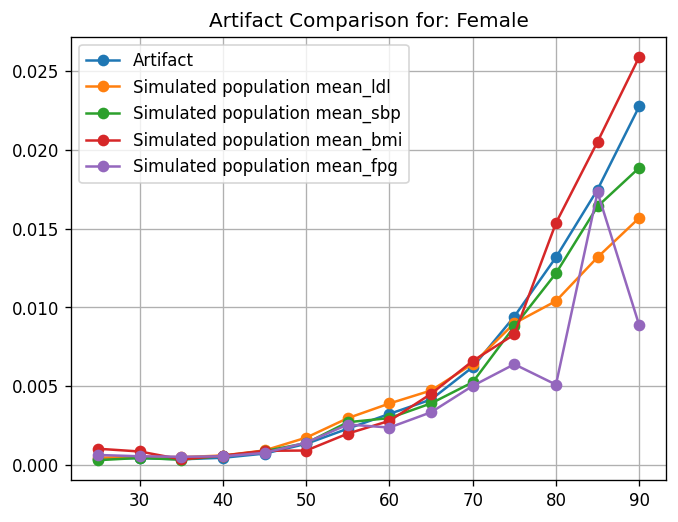

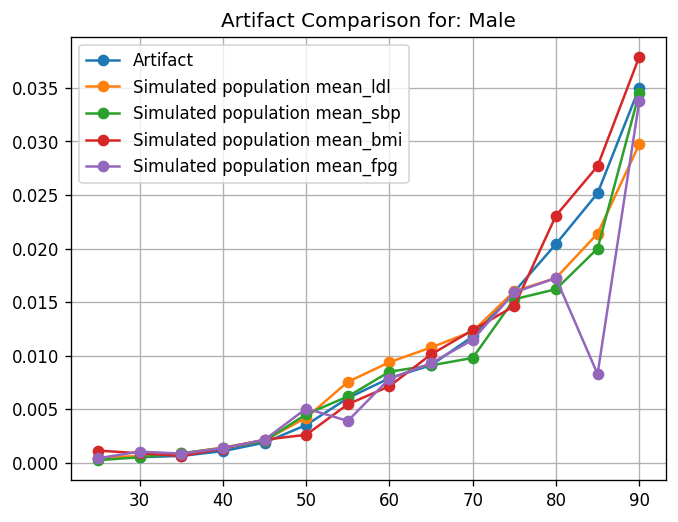

In [60]:
for sex in p.sex.unique():
    plt.figure(dpi=120)
    subdata = p.loc[p.sex == sex]
    plt.plot(subdata.age_start, subdata.inc, marker='o', label='Artifact')
    plt.plot(subdata.age_start, subdata.inc_i_ldl, marker='o', label='Simulated population mean_ldl')
    plt.plot(subdata.age_start, subdata.inc_i_sbp, marker='o', label='Simulated population mean_sbp')
    plt.plot(subdata.age_start, subdata.inc_i_bmi, marker='o', label='Simulated population mean_bmi')
    plt.plot(subdata.age_start, subdata.inc_i_fpg, marker='o', label='Simulated population mean_fpg')
    plt.legend()
    plt.title(f'Artifact Comparison for: {sex}') 
    plt.grid()

## Relative Risk and PAF Testing 
### Using the regression approach here since we don't have GBD values for RR and PAFs for HF 

Unfortunately that means we have to test single combos of causes and risks. I plan to focus on HF causes which are: HF with IHD and HF residual. Only SBP and BMI have an effect on HF. 

In [23]:
HF_regression = data1[['age_start','sex','high_sbp','high_bmi','high_ldl','hf_ihd','hf_resid','acute_mi']]
HF_regression['bmi_exposure'] = np.where(HF_regression.high_bmi < 22.5, 0, (HF_regression.high_bmi - 22.5))
HF_regression['sbp_exposure'] = np.where(HF_regression.high_sbp < 120, 0, (HF_regression.high_sbp - 120)/10)
HF_regression['hf_sum'] = HF_regression.hf_ihd + HF_regression.hf_resid
HF_regression.head()

,age_start,sex,high_sbp,high_bmi,high_ldl,hf_ihd,hf_resid,acute_mi,bmi_exposure,sbp_exposure,hf_sum
0,45.0,Female,127.134134,24.802611,2.644998,0.000024,0.000063,0.000012,2.302611,0.713413,0.000087
1,40.0,Male,131.808766,27.165902,3.376564,0.000020,0.000056,0.000022,4.665902,1.180877,0.000075
2,50.0,Female,106.466069,33.998750,2.074324,0.000052,0.000096,0.000031,11.498750,0.000000,0.000149
3,30.0,Male,109.868926,27.233734,3.756715,0.000012,0.000055,0.000005,4.733734,0.000000,0.000067
6,30.0,Male,132.593806,24.365348,1.946794,0.000017,0.000075,0.000003,1.865348,1.259381,0.000092


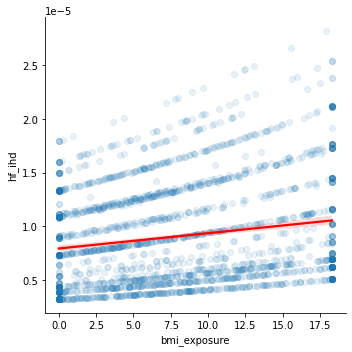

In [47]:
HF_regression_small = HF_regression.loc[(HF_regression.age_start < 40)]
sns.lmplot(x='bmi_exposure',y='hf_ihd',data=HF_regression_small, line_kws={'color': 'red'},scatter_kws={'alpha':0.1})

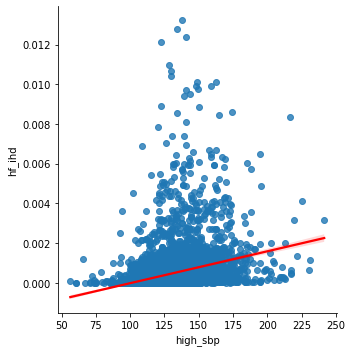

In [25]:
sns.lmplot(x='high_sbp',y='hf_ihd',data=HF_regression, line_kws={'color': 'red'})

In [ ]:
model = smf.logit("hf_ihd ~ bmi_exposure", data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='bmi_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df.head()

In [71]:
rel_risk = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk')
bmi_rr = (rel_risk
                .groupby(['affected_entity'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
bmi_rr_hf = bmi_rr.loc[(bmi_rr['affected_entity']=='heart_failure_from_ischemic_heart_disease')| (bmi_rr['affected_entity']=='heart_failure_residual')]
bmi_rr_hf.head()

,affected_entity,mean
3,heart_failure_from_ischemic_heart_disease,1.134219
4,heart_failure_residual,1.134219


In [ ]:
model = smf.logit('hf_resid ~ sbp_exposure', data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='sbp_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df

In [ ]:
model = smf.logit('hf_ihd ~ sbp_exposure', data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='sbp_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df

In [ ]:
model = smf.logit('hf_sum ~ sbp_exposure', data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='sbp_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df

In [ ]:
rel_risk = art.load('risk_factor.categorical_high_systolic_blood_pressure.relative_risk')
sbp_rr = (rel_risk
                .groupby(['affected_entity'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
sbp_rr_hf = sbp_rr.loc[(sbp_rr['affected_entity']=='heart_failure_from_ischemic_heart_disease') | (sbp_rr['affected_entity']=='heart_failure_residual')]
sbp_rr_hf.head()

In [ ]:
def load_artifact_key(word:str, cause:str, measure:str):
    data = pd.DataFrame()
    for i in ['alabama']:
        
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25', 'draw==0']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        data = art.load(word + '.' + cause + '.' + measure)
    return data

In [ ]:
data_MI = data1[['age_start','sex','high_ldl','high_sbp','high_bmi','high_fpg','acute_myocardial_infarction_event_count']]
data_MI['acute_MI_binary'] = np.where(data_MI['acute_myocardial_infarction_event_count'] == 0, 0, 1)
data_MI.head()

In [ ]:
art_MI_inc = load_artifact_key('cause', 'myocardial_infarction', 'incidence_rate')
art_MI_inc = art_MI_inc.rename(columns={"draw_0": "inc"}).reset_index()
art_MI_inc.head()

'risk_factor.high_ldl_cholesterol.relative_risk'

'risk_factor.high_ldl_cholesterol.population_attributable_fraction'

In [ ]:
art_MI_rr_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'relative_risk')
art_MI_rr_ldl = art_MI_rr_ldl.rename(columns={"draw_0": "rr_ldl"}).reset_index()
art_MI_rr_ldl = art_MI_rr_ldl.loc[art_MI_rr_ldl['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_ldl.head()

In [ ]:
art_MI_rr_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'relative_risk')
art_MI_rr_sbp = art_MI_rr_sbp.rename(columns={"draw_0": "rr_sbp"}).reset_index()
art_MI_rr_sbp = art_MI_rr_sbp.loc[art_MI_rr_sbp['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_sbp.head()

In [ ]:
art_MI_rr_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'relative_risk')
art_MI_rr_bmi = art_MI_rr_bmi.rename(columns={"draw_0": "rr_bmi"}).reset_index()
art_MI_rr_bmi = art_MI_rr_bmi.loc[art_MI_rr_bmi['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_bmi.head()

In [ ]:
art_MI_rr_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'relative_risk')
art_MI_rr_fpg = art_MI_rr_fpg.rename(columns={"draw_0": "rr_fpg"}).reset_index()
art_MI_rr_fpg = art_MI_rr_fpg.loc[art_MI_rr_fpg['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_fpg.head()

In [ ]:
art_MI_paf_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'population_attributable_fraction')
art_MI_paf_ldl = art_MI_paf_ldl.rename(columns={"draw_0": "paf_ldl"}).reset_index()
art_MI_paf_ldl = art_MI_paf_ldl.loc[art_MI_paf_ldl['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_ldl.head()

In [ ]:
art_MI_paf_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'population_attributable_fraction')
art_MI_paf_sbp = art_MI_paf_sbp.rename(columns={"draw_0": "paf_sbp"}).reset_index()
art_MI_paf_sbp = art_MI_paf_sbp.loc[art_MI_paf_sbp['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_sbp.head()

In [ ]:
art_MI_paf_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'population_attributable_fraction')
art_MI_paf_bmi = art_MI_paf_bmi.rename(columns={"draw_0": "paf_bmi"}).reset_index()
art_MI_paf_bmi = art_MI_paf_bmi.loc[art_MI_paf_bmi['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_bmi.head()

In [ ]:
art_MI_paf_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'population_attributable_fraction')
art_MI_paf_fpg = art_MI_paf_fpg.rename(columns={"draw_0": "paf_fpg"}).reset_index()
art_MI_paf_fpg = art_MI_paf_fpg.loc[art_MI_paf_fpg['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_fpg.head()

In [ ]:
from get_draws.api import get_draws
rrs_sbp = get_draws(gbd_id_type='rei_id',
               gbd_id=107,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_sbp = rrs_sbp.loc[rrs_sbp.cause_id==493]
rrs_sbp = rrs_sbp[['age_group_id','sex_id','draw_0']]
rrs_sbp['age_start'] = np.where(rrs_sbp['age_group_id']==10,25,np.where(rrs_sbp['age_group_id']==11,30,np.where(rrs_sbp['age_group_id']==12,35,np.where(rrs_sbp['age_group_id']==13,40,np.where(rrs_sbp['age_group_id']==14,45,np.where(rrs_sbp['age_group_id']==15,50,np.where(rrs_sbp['age_group_id']==16,55,np.where(rrs_sbp['age_group_id']==17,60,np.where(rrs_sbp['age_group_id']==18,65,np.where(rrs_sbp['age_group_id']==19,70,np.where(rrs_sbp['age_group_id']==20,75,np.where(rrs_sbp['age_group_id']==30,80,np.where(rrs_sbp['age_group_id']==31,85,np.where(rrs_sbp['age_group_id']==32,90,0))))))))))))))
rrs_sbp['sex'] = np.where(rrs_sbp['sex_id']==1,'Male','Female')
rrs_sbp = rrs_sbp.rename(columns={"draw_0": "rr_gbd_sbp"}).reset_index()
rrs_sbp.head()

In [ ]:
rrs = get_draws(gbd_id_type='rei_id',
               gbd_id=367,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs = rrs.loc[rrs.cause_id==493]
rrs = rrs[['age_group_id','sex_id','draw_0']]
rrs['age_start'] = np.where(rrs['age_group_id']==10,25,np.where(rrs['age_group_id']==11,30,np.where(rrs['age_group_id']==12,35,np.where(rrs['age_group_id']==13,40,np.where(rrs['age_group_id']==14,45,np.where(rrs['age_group_id']==15,50,np.where(rrs['age_group_id']==16,55,np.where(rrs['age_group_id']==17,60,np.where(rrs['age_group_id']==18,65,np.where(rrs['age_group_id']==19,70,np.where(rrs['age_group_id']==20,75,np.where(rrs['age_group_id']==30,80,np.where(rrs['age_group_id']==31,85,np.where(rrs['age_group_id']==32,90,0))))))))))))))
rrs['sex'] = np.where(rrs['sex_id']==1,'Male','Female')
rrs = rrs.rename(columns={"draw_0": "rr_gbd_ldl"}).reset_index()
rrs.head()

In [ ]:
rrs_bmi = get_draws(gbd_id_type='rei_id',
               gbd_id=370,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_bmi = rrs_bmi.loc[rrs_bmi.cause_id==493]
rrs_bmi = rrs_bmi[['age_group_id','sex_id','draw_0']]
rrs_bmi['age_start'] = np.where(rrs_bmi['age_group_id']==10,25,np.where(rrs_bmi['age_group_id']==11,30,np.where(rrs_bmi['age_group_id']==12,35,np.where(rrs_bmi['age_group_id']==13,40,np.where(rrs_bmi['age_group_id']==14,45,np.where(rrs_bmi['age_group_id']==15,50,np.where(rrs_bmi['age_group_id']==16,55,np.where(rrs_bmi['age_group_id']==17,60,np.where(rrs_bmi['age_group_id']==18,65,np.where(rrs_bmi['age_group_id']==19,70,np.where(rrs_bmi['age_group_id']==20,75,np.where(rrs_bmi['age_group_id']==30,80,np.where(rrs_bmi['age_group_id']==31,85,np.where(rrs_bmi['age_group_id']==32,90,0))))))))))))))
rrs_bmi['sex'] = np.where(rrs_bmi['sex_id']==1,'Male','Female')
rrs_bmi = rrs_bmi.rename(columns={"draw_0": "rr_gbd_bmi"}).reset_index()
rrs_bmi.head()

In [ ]:
rrs_fpg = get_draws(gbd_id_type='rei_id',
               gbd_id=105,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_fpg = rrs_fpg.loc[rrs_fpg.cause_id==493]
rrs_fpg = rrs_fpg[['age_group_id','sex_id','draw_0']]
rrs_fpg['age_start'] = np.where(rrs_fpg['age_group_id']==10,25,np.where(rrs_fpg['age_group_id']==11,30,np.where(rrs_fpg['age_group_id']==12,35,np.where(rrs_fpg['age_group_id']==13,40,np.where(rrs_fpg['age_group_id']==14,45,np.where(rrs_fpg['age_group_id']==15,50,np.where(rrs_fpg['age_group_id']==16,55,np.where(rrs_fpg['age_group_id']==17,60,np.where(rrs_fpg['age_group_id']==18,65,np.where(rrs_fpg['age_group_id']==19,70,np.where(rrs_fpg['age_group_id']==20,75,np.where(rrs_fpg['age_group_id']==30,80,np.where(rrs_fpg['age_group_id']==31,85,np.where(rrs_fpg['age_group_id']==32,90,0))))))))))))))
rrs_fpg['sex'] = np.where(rrs_fpg['sex_id']==1,'Male','Female')
rrs_fpg = rrs_fpg.rename(columns={"draw_0": "rr_gbd_fpg"}).reset_index()
rrs_fpg.head()

In [ ]:
tmrel_ldl = 1
tmrel_sbp = 112.5
tmrel_bmi = 22.5
tmrel_fpg = 5.1

data_merged = (data_MI.merge(art_MI_inc[['age_start','sex','inc']], on=['age_start','sex'])
               .merge(art_MI_paf_ldl[['age_start','sex','paf_ldl']], on=['age_start','sex'])
               .merge(art_MI_paf_sbp[['age_start','sex','paf_sbp']], on=['age_start','sex'])
               .merge(art_MI_paf_bmi[['age_start','sex','paf_bmi']], on=['age_start','sex'])
               .merge(art_MI_paf_fpg[['age_start','sex','paf_fpg']], on=['age_start','sex'])
              .merge(art_MI_rr_ldl[['age_start','sex','rr_ldl']], on=['age_start','sex'])
              .merge(art_MI_rr_sbp[['age_start','sex','rr_sbp']], on=['age_start','sex'])
              .merge(art_MI_rr_bmi[['age_start','sex','rr_bmi']], on=['age_start','sex'])
              .merge(art_MI_rr_fpg[['age_start','sex','rr_fpg']], on=['age_start','sex'])
              .merge(rrs[['age_start','sex','rr_gbd_ldl']], on=['age_start','sex'])
              .merge(rrs_bmi[['age_start','sex','rr_gbd_bmi']], on=['age_start','sex'])
              .merge(rrs_fpg[['age_start','sex','rr_gbd_fpg']], on=['age_start','sex'])
              .merge(rrs_sbp[['age_start','sex','rr_gbd_sbp']], on=['age_start','sex']))
data_merged['exposure_i_ldl'] = np.where(data_merged.high_ldl_cholesterol < 1, 0, (data_merged.high_ldl_cholesterol - tmrel_ldl))
data_merged['exposure_i_sbp'] = np.where(data_merged.high_sbp < 112.5, 0, (data_merged.high_sbp - tmrel_sbp)/10)
data_merged['exposure_i_bmi'] = np.where(data_merged.high_bmi < tmrel_bmi, 0, (data_merged.high_bmi - tmrel_bmi)/5)
data_merged['exposure_i_fpg'] = np.where(data_merged.high_fpg < tmrel_fpg, 0, (data_merged.high_fpg - tmrel_fpg))
data_merged['rr_i_ldl'] = np.exp(np.log(data_merged.rr_gbd_ldl) * data_merged.exposure_i_ldl)
data_merged['rr_i_sbp'] = np.exp(np.log(data_merged.rr_gbd_sbp) * data_merged.exposure_i_sbp)
data_merged['rr_i_bmi'] = np.exp(np.log(data_merged.rr_gbd_bmi) * data_merged.exposure_i_bmi)
data_merged['rr_i_fpg'] = np.exp(np.log(data_merged.rr_gbd_fpg) * data_merged.exposure_i_fpg)
data_merged['inc_i_ldl'] = data_merged.inc * (1 - data_merged.paf_ldl) * data_merged.rr_i_ldl
data_merged['inc_i_sbp'] = data_merged.inc * (1 - data_merged.paf_sbp) * data_merged.rr_i_sbp
data_merged['inc_i_bmi'] = data_merged.inc * (1 - data_merged.paf_bmi) * data_merged.rr_i_bmi
data_merged['inc_i_fpg'] = data_merged.inc * (1 - data_merged.paf_fpg) * data_merged.rr_i_fpg
data_merged.head()

In [ ]:
data_merged.loc[data_merged['inc_i_fpg']>1]

In [ ]:
#data_merged = data_merged.loc[data_merged['inc_i_sbp']<1]
#data_merged = data_merged.loc[data_merged['high_bmi']<70]
#data_merged = data_merged.loc[data_merged['high_fpg']<20]
p = data_merged.groupby(['sex','age_start','inc']).mean()[['inc_i_ldl','inc_i_sbp','inc_i_bmi','inc_i_fpg']].reset_index()

In [ ]:
p.head()

In [ ]:
for sex in p.sex.unique():
    plt.figure(dpi=120)
    subdata = p.loc[p.sex == sex]
    plt.plot(subdata.age_start, subdata.inc, marker='o', label='Artifact')
    plt.plot(subdata.age_start, subdata.inc_i_ldl, marker='o', label='Simulated population mean_ldl')
    plt.plot(subdata.age_start, subdata.inc_i_sbp, marker='o', label='Simulated population mean_sbp')
    plt.plot(subdata.age_start, subdata.inc_i_bmi, marker='o', label='Simulated population mean_bmi')
    plt.plot(subdata.age_start, subdata.inc_i_fpg, marker='o', label='Simulated population mean_fpg')
    plt.legend()
    plt.title(f'Artifact Comparison for: {sex}') 
    plt.grid()

There are some interesting things here for FPG - seems like a cluster of very high values in 80+ year olds which are leading to strange answers. Need to look into the exposure values further. Also the median is being odd? 

## Same approach for stroke

In [ ]:
data_stroke = data1[['age_start','sex','high_ldl_cholesterol','high_sbp','high_bmi','high_fpg','acute_ischemic_stroke_event_count']]
data_stroke = data_stroke.loc[data_stroke['age_start'] > 20]
data_stroke.head()

In [ ]:
art_stroke_inc = load_artifact_key('cause', 'ischemic_stroke', 'incidence_rate')
art_stroke_inc = art_stroke_inc.rename(columns={"draw_0": "inc"}).reset_index()
art_stroke_inc.head()

In [ ]:
art_stroke_rr_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'relative_risk')
art_stroke_rr_ldl = art_stroke_rr_ldl.rename(columns={"draw_0": "rr_ldl"}).reset_index()
art_stroke_rr_ldl = art_stroke_rr_ldl.loc[art_stroke_rr_ldl['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_ldl.head()

In [ ]:
art_stroke_rr_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'relative_risk')
art_stroke_rr_sbp = art_stroke_rr_sbp.rename(columns={"draw_0": "rr_sbp"}).reset_index()
art_stroke_rr_sbp = art_stroke_rr_sbp.loc[art_stroke_rr_sbp['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_sbp.head()

In [ ]:
art_stroke_rr_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'relative_risk')
art_stroke_rr_bmi = art_stroke_rr_bmi.rename(columns={"draw_0": "rr_bmi"}).reset_index()
art_stroke_rr_bmi = art_stroke_rr_bmi.loc[art_stroke_rr_bmi['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_bmi.head()

In [ ]:
art_stroke_rr_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'relative_risk')
art_stroke_rr_fpg = art_stroke_rr_fpg.rename(columns={"draw_0": "rr_fpg"}).reset_index()
art_stroke_rr_fpg = art_stroke_rr_fpg.loc[art_stroke_rr_fpg['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_fpg.head()

In [ ]:
art_stroke_paf_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'population_attributable_fraction')
art_stroke_paf_ldl = art_stroke_paf_ldl.rename(columns={"draw_0": "paf_ldl"}).reset_index()
art_stroke_paf_ldl = art_stroke_paf_ldl.loc[art_stroke_paf_ldl['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_ldl.head()

In [ ]:
art_stroke_paf_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'population_attributable_fraction')
art_stroke_paf_sbp = art_stroke_paf_sbp.rename(columns={"draw_0": "paf_sbp"}).reset_index()
art_stroke_paf_sbp = art_stroke_paf_sbp.loc[art_stroke_paf_sbp['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_sbp.head()

In [ ]:
art_stroke_paf_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'population_attributable_fraction')
art_stroke_paf_bmi = art_stroke_paf_bmi.rename(columns={"draw_0": "paf_bmi"}).reset_index()
art_stroke_paf_bmi = art_stroke_paf_bmi.loc[art_stroke_paf_bmi['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_bmi.head()

In [ ]:
art_stroke_paf_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'population_attributable_fraction')
art_stroke_paf_fpg = art_stroke_paf_fpg.rename(columns={"draw_0": "paf_fpg"}).reset_index()
art_stroke_paf_fpg = art_stroke_paf_fpg.loc[art_stroke_paf_fpg['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_fpg.head()

In [ ]:
rrs_sbp = get_draws(gbd_id_type='rei_id',
               gbd_id=107,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_sbp = rrs_sbp.loc[rrs_sbp.cause_id==495]
rrs_sbp = rrs_sbp[['age_group_id','sex_id','draw_0']]
rrs_sbp['age_start'] = np.where(rrs_sbp['age_group_id']==10,25,np.where(rrs_sbp['age_group_id']==11,30,np.where(rrs_sbp['age_group_id']==12,35,np.where(rrs_sbp['age_group_id']==13,40,np.where(rrs_sbp['age_group_id']==14,45,np.where(rrs_sbp['age_group_id']==15,50,np.where(rrs_sbp['age_group_id']==16,55,np.where(rrs_sbp['age_group_id']==17,60,np.where(rrs_sbp['age_group_id']==18,65,np.where(rrs_sbp['age_group_id']==19,70,np.where(rrs_sbp['age_group_id']==20,75,np.where(rrs_sbp['age_group_id']==30,80,np.where(rrs_sbp['age_group_id']==31,85,np.where(rrs_sbp['age_group_id']==32,90,0))))))))))))))
rrs_sbp['sex'] = np.where(rrs_sbp['sex_id']==1,'Male','Female')
rrs_sbp = rrs_sbp.rename(columns={"draw_0": "rr_gbd_sbp"}).reset_index()
rrs_sbp.head()

In [ ]:
rrs = get_draws(gbd_id_type='rei_id',
               gbd_id=367,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs = rrs.loc[rrs.cause_id==495]
rrs = rrs[['age_group_id','sex_id','draw_0']]
rrs['age_start'] = np.where(rrs['age_group_id']==10,25,np.where(rrs['age_group_id']==11,30,np.where(rrs['age_group_id']==12,35,np.where(rrs['age_group_id']==13,40,np.where(rrs['age_group_id']==14,45,np.where(rrs['age_group_id']==15,50,np.where(rrs['age_group_id']==16,55,np.where(rrs['age_group_id']==17,60,np.where(rrs['age_group_id']==18,65,np.where(rrs['age_group_id']==19,70,np.where(rrs['age_group_id']==20,75,np.where(rrs['age_group_id']==30,80,np.where(rrs['age_group_id']==31,85,np.where(rrs['age_group_id']==32,90,0))))))))))))))
rrs['sex'] = np.where(rrs['sex_id']==1,'Male','Female')
rrs = rrs.rename(columns={"draw_0": "rr_gbd_ldl"}).reset_index()
rrs.head()

In [ ]:
rrs_bmi = get_draws(gbd_id_type='rei_id',
               gbd_id=370,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_bmi = rrs_bmi.loc[rrs_bmi.cause_id==495]
rrs_bmi = rrs_bmi[['age_group_id','sex_id','draw_0']]
rrs_bmi['age_start'] = np.where(rrs_bmi['age_group_id']==10,25,np.where(rrs_bmi['age_group_id']==11,30,np.where(rrs_bmi['age_group_id']==12,35,np.where(rrs_bmi['age_group_id']==13,40,np.where(rrs_bmi['age_group_id']==14,45,np.where(rrs_bmi['age_group_id']==15,50,np.where(rrs_bmi['age_group_id']==16,55,np.where(rrs_bmi['age_group_id']==17,60,np.where(rrs_bmi['age_group_id']==18,65,np.where(rrs_bmi['age_group_id']==19,70,np.where(rrs_bmi['age_group_id']==20,75,np.where(rrs_bmi['age_group_id']==30,80,np.where(rrs_bmi['age_group_id']==31,85,np.where(rrs_bmi['age_group_id']==32,90,0))))))))))))))
rrs_bmi['sex'] = np.where(rrs_bmi['sex_id']==1,'Male','Female')
rrs_bmi = rrs_bmi.rename(columns={"draw_0": "rr_gbd_bmi"}).reset_index()
rrs_bmi.head()

In [ ]:
rrs_fpg = get_draws(gbd_id_type='rei_id',
               gbd_id=105,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_fpg = rrs_fpg.loc[rrs_fpg.cause_id==495]
rrs_fpg = rrs_fpg[['age_group_id','sex_id','draw_0']]
rrs_fpg['age_start'] = np.where(rrs_fpg['age_group_id']==10,25,np.where(rrs_fpg['age_group_id']==11,30,np.where(rrs_fpg['age_group_id']==12,35,np.where(rrs_fpg['age_group_id']==13,40,np.where(rrs_fpg['age_group_id']==14,45,np.where(rrs_fpg['age_group_id']==15,50,np.where(rrs_fpg['age_group_id']==16,55,np.where(rrs_fpg['age_group_id']==17,60,np.where(rrs_fpg['age_group_id']==18,65,np.where(rrs_fpg['age_group_id']==19,70,np.where(rrs_fpg['age_group_id']==20,75,np.where(rrs_fpg['age_group_id']==30,80,np.where(rrs_fpg['age_group_id']==31,85,np.where(rrs_fpg['age_group_id']==32,90,0))))))))))))))
rrs_fpg['sex'] = np.where(rrs_fpg['sex_id']==1,'Male','Female')
rrs_fpg = rrs_fpg.rename(columns={"draw_0": "rr_gbd_fpg"}).reset_index()
rrs_fpg.head()

In [ ]:
tmrel_ldl = 1
tmrel_sbp = 112.5
tmrel_bmi = 22.5
tmrel_fpg = 5.1

data_merged = (data_stroke.merge(art_stroke_inc[['age_start','sex','inc']], on=['age_start','sex'])
               .merge(art_stroke_paf_ldl[['age_start','sex','paf_ldl']], on=['age_start','sex'])
               .merge(art_stroke_paf_sbp[['age_start','sex','paf_sbp']], on=['age_start','sex'])
               .merge(art_stroke_paf_bmi[['age_start','sex','paf_bmi']], on=['age_start','sex'])
               .merge(art_stroke_paf_fpg[['age_start','sex','paf_fpg']], on=['age_start','sex'])
              .merge(art_stroke_rr_ldl[['age_start','sex','rr_ldl']], on=['age_start','sex'])
              .merge(art_stroke_rr_sbp[['age_start','sex','rr_sbp']], on=['age_start','sex'])
              .merge(art_stroke_rr_bmi[['age_start','sex','rr_bmi']], on=['age_start','sex'])
              .merge(art_stroke_rr_fpg[['age_start','sex','rr_fpg']], on=['age_start','sex'])
              .merge(rrs[['age_start','sex','rr_gbd_ldl']], on=['age_start','sex'])
              .merge(rrs_bmi[['age_start','sex','rr_gbd_bmi']], on=['age_start','sex'])
              .merge(rrs_fpg[['age_start','sex','rr_gbd_fpg']], on=['age_start','sex'])
              .merge(rrs_sbp[['age_start','sex','rr_gbd_sbp']], on=['age_start','sex']))
data_merged['exposure_i_ldl'] = np.where(data_merged.high_ldl_cholesterol < 1, 0, (data_merged.high_ldl_cholesterol - tmrel_ldl))
data_merged['exposure_i_sbp'] = np.where(data_merged.high_sbp < 112.5, 0, (data_merged.high_sbp - tmrel_sbp)/10)
data_merged['exposure_i_bmi'] = np.where(data_merged.high_bmi < tmrel_bmi, 0, (data_merged.high_bmi - tmrel_bmi)/5)
data_merged['exposure_i_fpg'] = np.where(data_merged.high_fpg < tmrel_fpg, 0, (data_merged.high_fpg - tmrel_fpg))
data_merged['rr_i_ldl'] = np.exp(np.log(data_merged.rr_gbd_ldl) * data_merged.exposure_i_ldl)
data_merged['rr_i_sbp'] = np.exp(np.log(data_merged.rr_gbd_sbp) * data_merged.exposure_i_sbp)
data_merged['rr_i_bmi'] = np.exp(np.log(data_merged.rr_gbd_bmi) * data_merged.exposure_i_bmi)
data_merged['rr_i_fpg'] = np.exp(np.log(data_merged.rr_gbd_fpg) * data_merged.exposure_i_fpg)
data_merged['inc_i_ldl'] = data_merged.inc * (1 - data_merged.paf_ldl) * data_merged.rr_i_ldl
data_merged['inc_i_sbp'] = data_merged.inc * (1 - data_merged.paf_sbp) * data_merged.rr_i_sbp
data_merged['inc_i_bmi'] = data_merged.inc * (1 - data_merged.paf_bmi) * data_merged.rr_i_bmi
data_merged['inc_i_fpg'] = data_merged.inc * (1 - data_merged.paf_fpg) * data_merged.rr_i_fpg
data_merged.head()

In [ ]:
#data_merged = data_merged.loc[data_merged['inc_i_sbp']<1]
p = data_merged.groupby(['sex','age_start','inc']).mean()[['inc_i_ldl','inc_i_sbp','inc_i_bmi','inc_i_fpg']].reset_index()

In [ ]:
for sex in p.sex.unique():
    plt.figure(dpi=120)
    subdata = p.loc[p.sex == sex]
    plt.plot(subdata.age_start, subdata.inc, marker='o', label='Artifact')
    plt.plot(subdata.age_start, subdata.inc_i_ldl, marker='o', label='Simulated population mean_ldl')
    plt.plot(subdata.age_start, subdata.inc_i_sbp, marker='o', label='Simulated population mean_sbp')
    plt.plot(subdata.age_start, subdata.inc_i_bmi, marker='o', label='Simulated population mean_bmi')
    plt.plot(subdata.age_start, subdata.inc_i_fpg, marker='o', label='Simulated population mean_fpg')
    plt.legend()
    plt.title(f'Artifact Comparison for: {sex}') 
    plt.grid()

Less here, this matches with what we saw in the other notebook - MI is more worrisome 